In [2]:
import numpy as np
import pandas as pd
import os
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import inspect
#import sys
import logging

In [3]:
#path = R"C:\Users\ringel\Lokal\Python-local\ProSi3D\brosev2_19112021"
#path = R"D:\Python\Prosi"
path = R'D:\ProSi3D-python\brosev2_19112021'
correction = 0
path = R"C:\Users\ringel\Lokal\Python-local\Fabian_26012022"

In [4]:
def folder2Files(path, stdprnt=1):
    """
    Use path as dir to project. Put inside *openjz.txt file, *.openjobfile and *_param.csv
    This functions helps to organize files in projectfolder by file-type
    Args: filepath
    Returns: eostxtfile, paramfile, jobfile, vecdir
    """

    files = [f.path for f in os.scandir(path)]
    #list_subfolders_with_paths = [f.path for f in os.scandir(path) if f.is_dir()]
    for fname in files:
        if fname[-11:] == '.openjz.txt':
            eostxtfile = fname
        if fname[-9:] == 'param.csv':
            paramfile = fname
        if fname[-8:] == '.openjob':
            jobfile = fname
    
    if 'eostxtfile' in locals():
        if stdprnt==1:
            print(eostxtfile)
    else:
        print('eostxtfile is not defined')
        eostxtfile = False
        
    if 'paramfile' in locals():
        if stdprnt==1:
            print(paramfile)
    else:
        print('paramfile is not defined')
        paramfile = False
        
    if 'jobfile' in locals():
        if stdprnt==1:
            print(jobfile)
    else:
        print('jobfile is not defined')
        jobfile = False
    
    vecdir = path + '\\vec'
    try:
        os.mkdir(vecdir)
    except:
        pass

    pdfdir = path + '\\pdf'
    try:
        os.mkdir(pdfdir)
    except:
        pass

    ttldir = path + '\\ttl'
    try:
        os.mkdir(ttldir)
        print(f'TTL Signal files missing. Put them in: {ttldir}')
    except:
        pass

    resdir = path + '\\res'
    try:
        os.mkdir(resdir)
    except:
        pass

    logdir = path + '\\log'
    try:
        os.mkdir(logdir)
    except:
        pass

    return eostxtfile, paramfile, jobfile, vecdir, ttldir, resdir, logdir

In [5]:
# define custom logging
eostxtfile, paramfile, jobfile, vecdir, ttldir, resdir, logdir = folder2Files(path, 0)
logfile = logdir + '\\' + path.rsplit('\\',1)[-1] + '.log'

# remove handler to fix file not written
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(level = logging.DEBUG,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%d.%m.%y %H:%M:%S',
                    filename=logfile,
                    filemode='w')
console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
console.setFormatter(formatter)
logging.getLogger().addHandler(console)

In [17]:
def readDf(path):
    """
    Reads txt-File exported via EOSPRINTAPI from *openjz.txt build-preview-file. Deletes non numeric numbers and calculates layerchanges.
    returns df: array with vector-tuple in rows and columns: x_mm, y_mm, exposureType, partId
    returns layers: list of layerchangelineindexes starting with change from 1 to 2
    returns vecdir where eosprint_layer files are stored via function df2layers
    
    Args: eostxtfilepath
    Returns: df, layers, vecdir
    """
    print('>>>>>>>>>> ', inspect.currentframe().f_code.co_name, inspect.getargvalues(inspect.currentframe()).locals)
    logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    out = '>>>>>>>>>> ' + str(inspect.getargvalues(inspect.currentframe()).locals)
    logger.info(out)

    eostxtfile, _, jobfile, vecdir, _, _, logdir = folder2Files(path)
    
    df = pd.read_csv(eostxtfile, sep=',', header=None, error_bad_lines=False, warn_bad_lines=True, skiprows=4)
    
    ## re-define columnheader
    df.columns = ['x_mm', 'y_mm', 'exposureType', 'partId']
    
    # Delete non numeric letters in data
    df[df.columns[0]] = df[df.columns[0]].map(lambda x: str(x)[6:])
    df[df.columns[1]] = df[df.columns[1]].map(lambda x: str(x)[6:])
    df[df.columns[2]] = df[df.columns[2]].map(lambda x: str(x)[14:])
    df[df.columns[3]] = df[df.columns[3]].map(lambda x: str(x)[8:])
       
    # delete exposureType 0, which is just for visualization of part boundaries
    df = df.drop(df.loc[df.exposureType == ' 0'].index)
    df = df.reset_index(drop=True)
    
    # create variable for where layers change in new var layers
    layers = df[df['x_mm'].str.contains("ewdata")]
    
    # just first column is relevant here, drop others
    layers = layers.drop(['y_mm', 'exposureType', 'partId'], axis='columns')
    layers.columns = ['Layer']
    
    ## Delete lines were new layer starts and reset index numbering
    df = df.drop(layers.index, axis=0)
    df = df.reset_index(drop=True)

    # logging
    fname = jobfile[:-8]
    delim = '\\'
    logger.info(f'Job: {fname.rsplit(delim,1)[-1]} has {len(layers)} layers with {len(df)/2} total vectors.')

    return df, layers, vecdir

def df2Layers_hdf(df, layers, vecdir):
    """
    Follows function readDf(). slice and save dataframe into layerwise hdf5-files with columns: x_mm, y_mm, exposureType, partId
    Indexes from original dataframe are used -> first index of layer n>1 is not 0
    
    Args: df, layers, vecdir
    Returns: >saves layerwise eosprint-vector-data in hdf5 file format: e.g.:eosprint_layer00001.h5<
    """
    logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    #logger.info('>>>>>>>>>> ', inspect.currentframe().f_code.co_name)#, inspect.getargvalues(inspect.currentframe()).locals)
    out = '>>>>>>>>>> ' + str(inspect.currentframe().f_code.co_name)
    logger.info(out)
    
    # following does not make sense for arrays -> full list 
    #logger.info(inspect.getargvalues(inspect.currentframe()).locals)

    # make numbers - a lot of cpu time necessary
    df['x_mm'] = pd.to_numeric(df['x_mm'],downcast='float')
    df['y_mm'] = pd.to_numeric(df['y_mm'],downcast='float')
    df['exposureType'] = pd.to_numeric(df['exposureType'],downcast='integer')
    df['partId'] = pd.to_numeric(df['partId'],downcast='integer')
    
    # count layers
    size = layers.shape[0] + 1
    size = str(size)
    j = 0
    
    # slice dataframe by loop through layers list indexes = i
    lay = 1
    for i, _ in layers.iterrows():
        f = vecdir + '\\' + "eosprint_layer" + str(lay).zfill(5) + ".h5"
        ii = i - (lay - 1)
        df[j:ii].to_hdf(f, key='df', mode='w')
        #logger.info(f + ' von ' + size + ' Schichten gespeichert.')
        j = ii
        lay+=1
    f = vecdir + '\\' + "eosprint_layer" + str(lay).zfill(5) + ".h5"
    df[j:].to_hdf(f, key='df', mode='w')
    logger.info('Last file: ' + f + ' of ' + size + ' Layers saved.')
    logger.info('Original layer data from EOSPRINT have been saved to separate h5 Files. Except lines where exposureType equals zero.')
    return vecdir

def jumpAcceleration(dis, lin=0):
    '''
    Called by vecTiming_hdf(). Calculates mean jump speed for jumptimecalculation based on
    lin=0: log regression of measured values
    lin=1: linear regression values

    Args: dis, lin=0
    Returns: mean_jump_speed
    '''
    logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    out = '>>>>>>>>>> ' + str(inspect.currentframe().f_code.co_name)
    logger.info(out)
    
    #logger.info(inspect.getargvalues(inspect.currentframe()).locals)

    # damit log(<1) nicht negativ
    #da = dis*1000
    if lin == 0:
        da = dis*1000
    else:
        da = dis
    # x = distance; y = measured mean speed  
    # v_mean = -0.0001*np.power(dis, 4) + 0.0437*np.power(dis, 3) - 5.6237*np.power(dis, 2) + 273.54*dis + 513.48
    da = da.to_frame().copy()
    da['v_mean'] = 1
    da['time'] = 2
    da.columns=['dis','v_mean', 'time']
    if lin == 0:
        # mean speed as log function from 0,256 mm jump distance
        # 737075ln(x) - 4E+06 | alle R2=0,8671
        # speeds below welding speeds dont make sense
        korr = 170000
        #da.v_mean.loc[da.dis > 1230] = 800000*np.log(da.dis) - 4E+06
        #da.v_mean.loc[da.dis < 1230] = 1600000 - 120000
        da.v_mean.loc[da.dis > 1230] = 787181*np.log(da.dis.copy()) - 4E+06
        da.v_mean.loc[da.dis < 1230] = 1600000 - 120000
        da.v_mean = da.v_mean/1000
    
    # == 1 needs file with correlation table geometric jump lens vs times
    if lin == 1:
        # change number to layer and give this function layer numbers to apply layer-specific correction tables
        f = "jump_data" + str(582).zfill(5) + ".h5"
        dbase = pd.read_hdf(f, 'dbase')
        dbase_sort = dbase.sort_values(by=['dis_eos', 'v_mean'])
        interpol = interp1d(dbase_sort.dis_eos, dbase_sort.v_mean, bounds_error=False)
        da['v_mean'] = interpol(da.dis)
        
        #target.time_ttl.loc[target.time_ttl.isna()] = target_init.time_ttl.loc[target.time_ttl.isna()]
    if lin == 2:
        da.time = 0.0002*da.dis + 0.0008
        da.v_mean = da.dis/da.time
    da.v_mean.loc[da.v_mean > 5500] = 5500
    da.v_mean.loc[da.v_mean == -np.inf] = 7000
    da.v_mean.loc[da.v_mean == 0] = 0
    
    #global jumpAccs
    mean_jump_speed = da.v_mean.copy()
    return mean_jump_speed

def vecTiming_hdf(path,lay=1,debug=0,readonly=0, changeExposure=1):
    '''
    Layerwise dataframe must be in file-name-format: eosprint_layer00001.h5 in path/vec
    Calculates time for each x,y point in df regarding laser speeds from _param.csv and forecasted jump speeds.
    Saves edit to files with format: eoslaserpath_00001.h5
    Needings: edited *_param.csv, eosprint_layer00001.h5-files, jumpAcceleration()
    debug = 1 makes eos_jump, eos_laser global variables, debug = 2 returns eos_jump, eos_laser, readonly=1 does not save.

    some slice error is still present after calling jumpAcceleration()
    
    A value is trying to be set on a copy of a slice from a DataFrame

    See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
    self._setitem_with_indexer(indexer, value)
    C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame

        
    Args: path, lay=1,debug=0,readonly=0, changeExposure=1
    Returns: >saves files< "eoslaserpath_00001.h5", except: debug modes give values back
    '''
    #print('>>>>>>>>>> ', inspect.currentframe().f_code.co_name, inspect.getargvalues(inspect.currentframe()).locals)
    # set logger with function name
    logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    # log output function and arguments
    out = '>>>>>>>>>> ' + str(inspect.getargvalues(inspect.currentframe()).locals)
    logger.info(out)

    # get filenames without printing
    _, paramfile, _, vecdir, _, _, logdir = folder2Files(path, 0)
    
    # read paramfile
    param = pd.read_csv(paramfile, sep=';')
    param.columns = ['partid', 'partname', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
    # true partid starts counting by 1
    param.partid = param.partid + 1
    
    # loop through all files in folder with eoslaserpath_#####.h5-files
    files = [f.path for f in os.scandir(vecdir)]

    for fname in files:
        # skip other files
        dummy = 'eosprint_layer00001.h5'
        checker = fname.rsplit('\\',1)[-1]
        if len(checker) != len(dummy) or checker[:14] != dummy[:14]:
            continue

        df = pd.read_hdf(fname, 'df')
        # reset index
        df = df.reset_index(drop=True)
        
        # if following coordinate equals, then distance is simply zero
        # Diff calculates the difference of a Dataframe element compared with another element in the Dataframe (in previous row).
        # since it is just one column there is no axis option
        # periods=-1 --> diff of row "minus" following row => line 1 = line 1 minus line 2 and so on
        # (two lines define one vektor. first line saves distance value of tuple)
        df['dx'] = df['x_mm'].diff(periods=-1)
        df['dy'] = df['y_mm'].diff(periods=-1)
        
        # calulate distances via pythagoras. root of squared sum.
        df['dx2'] = df['dx'].pow(2)
        df['dy2'] = df['dy'].pow(2)
        df['dis'] = df[['dx2','dy2']].sum(axis=1).pow(1./2)
        # dis: line 1 = line 1 minus line 2 and so on
        
        # angle of single vector in coordinate system
        df['angle'] = np.rad2deg(np.arctan2(df['dy'], df['dx']))
        
        # angle of following laser (analog jump) vectors to find out if skywriting could be active between
        # line 1 = line 1 minus line 3, line 2 = line 2 minus line 4 and so on
        df['dphi'] = df['angle'].diff(periods=-2)
        
        # Shift column dphi in axis row by +1 to have "180" in the line of jump
        #df.dphi=df.dphi.shift(periods=1, axis=0, fill_value=0)
        
        # correct wrong definition of contour exposureType in eos print export data
        # wrong contours have expType = 2 instead of 5 because of mistake in eosprint api
        if changeExposure == 1:
            
            # contours always have equal end and starting points --> checker for wrong expType
            # create index list for where length of jump is zero and exposuretype is 2, then change to 5. without entries with NaN (last row)
            ind4Change = df.loc[(df.dis == 0) & (df.exposureType == 2) & (df.dx.isna() == False) & (df.dy.isna() == False)].index
            #ind4Change = df.loc[((np.abs(round(df.dphi,0))==90) | (np.abs(round(df.dphi,0))==270)) & (df.dis == 0) & (df.exposureType == 2)].index
                
            # change exposureType for found jumps with length zero (actual vector pair and following pair)
            df.loc[(ind4Change-1 | ind4Change | ind4Change+1 | ind4Change+2), 'exposureType'] = 5

            logger.info(f'Changed exposures in n pairs: {len(ind4Change)}')
            
        # assign speeds regarding partId and exposureType
        #df['v'] = speedFromCSV(df[['exposureType','partId']])
        parts = df['partId'].unique()
        for part in parts:
            # select all exposures for this partid
            exp_types = df.loc[(df['partId'] == part), 'exposureType'].unique()
            for exptype in exp_types:
                speedval = param.loc[(param['partid'] == part), str(exptype)]
                df.loc[(df['exposureType'] == exptype) & (df['partId'] == part), 'v'] = speedval.iloc[0]
        ### from here welding speeds are assigned to parts and exposureTypes correctly
        ### following jump speeds are corrected
        
        # overwrite jump speeds between vector pairs (alternating from vector pairs)
        # odd line number count: vector pairs start from 2nd+3rd entry. first koordinate tuple is ignored. maybe laser initialization.
        #speed_jump = 2900
        if len(df)%2 == 1:
            # first layer
            # is first jump visible because laser was not on before?
            df.v.iloc[0::2] = jumpAcceleration(df.dis.iloc[0::2].copy())
        # even line count: start with first line
        else:
            # except first layer
            df.v.iloc[1::2] = jumpAcceleration(df.dis.iloc[1::2].copy())
        
        # t = s/v
        df['time'] = df['dis'].div(df['v'])
        # correct really short jumps to a minimum value
        if len(df)%2 == 1:
            df.time.loc[(df.time < 0.000504) & ((df.index)%2 == 0) & (df.dis != 0)] = 0.000504
        else:
            df.time.loc[(df.time < 0.000504) & ((df.index)%2 == 1) & (df.dis != 0)] = 0.000504
        
        ## Skywriting corrections turned of because precise correction is done in another function "redefinelaserpathstarts()"
        # add timeconstant for skywriting if oneeightee
        #k_skywriting-offset around 0.00050 combined with logarithmic speed regression
        #t_skywriting = 0.000475
        #df.loc[(np.abs(df.dphi) < 181) & (np.abs(df.dphi) > 179) & (df.dis !=0), 'time'] = df.loc[(np.abs(df.dphi) < 181) & (np.abs(df.dphi) > 179) & (df.dis !=0), 'time'] + t_skywriting        
        # may there is an additional distance rule necessary: skywriting only if endpoint is near/next to starting point
        #df.loc[(np.abs(df.dphi) < 181) & (np.abs(df.dphi) > 179) & (df.dis < 1) & (df.dis != 0), 'time'] = df.loc[(np.abs(df.dphi) < 181) & (np.abs(df.dphi) > 179) & (df.dis < 1) & (df.dis != 0), 'time'] + 0.46

        # cumulative sum of time -> timerow like timestamps
        df['cum_sum'] = df['time'].cumsum()
        
        ## first layer has odd line number count and pairs start from 2nd+3rd entry. first koordinate tuple is ignored. dunno why.
        # all the others have even line count and start from first layer
        if len(df)%2 == 1:
            df_laser = df.iloc[1::2].copy()
            df_jump = df.iloc[0::2].copy()
        else:
            df_laser = df.iloc[0::2].copy()
            df_jump = df.iloc[1::2].copy()
        
        df_laser['cum_sum'] = df_laser['time'].cumsum()
        df_jump['cum_sum'] = df_jump['time'].cumsum()
        
        #logger.info(f"(df_laser.dis == 0).sum() = {(df_laser.dis == 0).sum()}")
        if readonly == 0:
            f = vecdir + '\\' + "eoslaserpath_" + fname[-8:]
            df[['x_mm','y_mm','exposureType','partId','v','dis','angle','dphi','time','cum_sum']].to_hdf(f, key='df', mode='w')
            #f = vecdir + '\\' + "vectortimes" + fname[-14:]
            #df[['time','cum-sum','dis','angle', 'dphi']].to_hdf(f, key='df', mode='w')
            logger.info(fname + ' gespeichert.')
    
    # why is laser and jump 0 1 flipped in debug mode?
    if debug == 1:
        global eos_laser, eos_jump
        if len(df)%2 == 1:
            # laser is len of jumps at laser start
            eos_laser = df.iloc[0::2].copy()
            eos_jump = df.iloc[1::2].copy()
        else:
            eos_laser = df.iloc[1::2].copy()
            eos_jump = df.iloc[0::2].copy()
    if debug == 2:
        if len(df)%2 == 1:
            # laser is len of jumps at laser start
            eos_laser = df.iloc[0::2]
            eos_jump = df.iloc[1::2]
        else:
            eos_laser = df.iloc[1::2]
            eos_jump = df.iloc[0::2]
        return eos_jump, eos_laser
    
    
def listpar(path):
    '''
    helper function to create csv with all occuring parameter names to then add DOE values manually to this file before calling vecTiming_hdf()

    Args: path
    Returns: <save empty parameter file with partnumbers (partId = partnumber+1) and assigned parameter names>
    '''
    
    #print('>>>>>>>>>> ', inspect.currentframe().f_code.co_name, inspect.getargvalues(inspect.currentframe()).locals)
    logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    out = '>>>>>>>>>> ' + str(inspect.getargvalues(inspect.currentframe()).locals)
    logger.info(out)
    
    _, _, jobfile, _, _, _, _ = folder2Files(path,0)
    
    f = open(jobfile, 'r')
    df = f.readlines()
    partlist = []
    paramlist = []
    i = 0
    for line in df:
        if i == 0:
            vers = line.find('creator_version')
            logger.info(line[vers:])
                
        pos_par = line.find('<parameter>')
        if pos_par != -1:
            s = pos_par + 11
            e = line.find('</parameter>', s)
            param = line[s:e]
            paramlist.append(param)
            
            s = prev_line.find(' name="') + 7
            e = prev_line.find('"', s)
            part = prev_line[s:e]
            partlist.append(part)
            
        prev_line = line
        i += 1
    
    parlist = pd.DataFrame(paramlist)
    parlist.to_csv(jobfile[:-8] + '_param.csv', sep=';')
    logger.info(f'Parametersets: {len(paramlist)}, Teileanzahl: {len(partlist)}')
#    return paramlist, partlist

def loopRedefinelaserpaths(path, correction=0):
    '''
    Checks matching eosprint_layer and ch4raw_ files in subfolders of path and loops redefinelaserpathstarts() over those matching files.
    Use correction!=0 layer numbers do not equal, e.g. eosprint_layer00001 belongs to ch4raw_00003: correction=2
    
    Args: path, correction=0
    Returns: matches
    '''
    #print('>>>>>>>>>> ', inspect.currentframe().f_code.co_name, inspect.getargvalues(inspect.currentframe()).locals)
    logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    out = '>>>>>>>>>> ' + str(inspect.getargvalues(inspect.currentframe()).locals)
    logger.info(out)

    eostxtfile, paramfile, jobfile, vecdir, ttldir, resdir, logdir = folder2Files(path, 0)

    eoslayers = []
    ttllayers = []

    # check files by string and positions
    eosfiles = [f.path for f in os.scandir(vecdir)]
    for item in eosfiles:
        item = item.rsplit('eoslaserpath_')[-1]
        item = item.rsplit('.', 1)[0]
        try:
            num = int(item)
        except:
            continue
        if item == str(num).zfill(5):
            eoslayers.append(num)

    ttlfiles = [f.path for f in os.scandir(ttldir)]
    for item in ttlfiles:
        item = item.rsplit('ch4raw_')[-1]
        item = item.rsplit('.', 1)[0]
        try:
            num = int(item)
        except:
            continue
        if item == str(num).zfill(5):
            ttllayers.append(num)

    eoslayers = np.array(eoslayers)
    ttllayers = np.array(ttllayers)+correction

    matches = eoslayers[np.isin(eoslayers,ttllayers)]
    logger.info(f"Found correlating files: {list(matches)}")

    for lay in matches:
        try:
            redefinelaserpathstarts(lay, correction)
        except:
            logger.info(f"ERROR: {lay} could not be processed. Check manually!")
            pass
    
    return matches
    

# getLoss(eos_laser_single, swelds.index[0])
def getLoss(eos_laser_single, jmp_strt_lsr_len):
    '''
    Calculate losses between eos_laser_single['time'] and jmp_strt_lsr_len['diff_ms']. Called by redefinelaserpathstarts()

    Args: eos_laser_single, jmp_strt_lsr_len
    Returns: eos_laser_single
    '''

    eos_laser_single['ttl'] = jmp_strt_lsr_len['diff_ms']
    eos_laser_single['loss'] = (eos_laser_single['time'] - jmp_strt_lsr_len['diff_ms']) / eos_laser_single['time']
    eos_laser_single['diffeos'] = eos_laser_single['time'].diff()
    eos_laser_single['diffttl'] = jmp_strt_lsr_len['diff_ms'].diff()
    eos_laser_single['loss2'] = (eos_laser_single['diffeos'] - eos_laser_single['diffttl']) / eos_laser_single['diffeos']

    return eos_laser_single

def chkLossMove(eos_laser_single, jmp_strt_lsr_len, errIndex, chk_time_ms, chk_loss):
    '''
    Testrop with recalculation of loss. Called by redefinelaserpathstarts() while searching for issues in each iteration.

    Args: eos_laser_single, jmp_strt_lsr_len, errIndex, chk_time_ms, chk_loss
    Returns: eos_laser_single_drop, loss_viol_move, droppedtrueindex
    '''
    # errIndex is position to drop in eos_laser_single
    # chk_time_ms, chk_loss are predifend values for loss check
    # swelds_io_idx is position until where problems are already fixed
    print(eos_laser_single.loc[errIndex-2:errIndex+2])
    # drop copy
    eos_laser_single_drop = eos_laser_single.copy()
    # true index of eos data for dropped
    droppedtrueindex = eos_laser_single['idx'].loc[errIndex]
    # drop inplace would change original too even if outside loop
    eos_laser_single_drop.drop(errIndex, inplace=True)
    eos_laser_single_drop.reset_index(drop=True, inplace=True)

    ## recalculate losses
    eos_laser_single_drop = getLoss(eos_laser_single_drop, jmp_strt_lsr_len)
    # get new problematic position
    #loss_viol_move = eos_laser_single_drop.loc[(eos_laser_single_drop['time'] > chk_time_ms) & (abs(eos_laser_single_drop['loss']) > chk_loss) & (eos_laser_single_drop.index > swelds_io_idx)].index[0]
    lossfilter = eos_laser_single_drop.loc[(eos_laser_single_drop['time'] > chk_time_ms) & (abs(eos_laser_single_drop['loss']) > chk_loss)]
    if lossfilter.shape[0] > 0:
        loss_viol_move = lossfilter.index[0]
    else:
        loss_viol_move = -1


    return eos_laser_single_drop, loss_viol_move, droppedtrueindex

def getBoarders(eos_laser_single, jmp_strt_lsr_len, board_min_time_ms):
    '''
    Called by redefinelaserpathstarts. Calculation of long boarders (> board_min_time_ms) for validation of synchronization.
    Not really necessary at the moment (23.02.2022)
    
    Args: eos_laser_single, jmp_strt_lsr_len, board_min_time_ms
    Returns: eosboarders, use_boarders, sh_boarder_idxs
    '''
    use_boarders = False
    # filter boarders
    eosboarders = eos_laser_single.loc[(eos_laser_single['exposureType'] == 5) & (eos_laser_single['time'] > board_min_time_ms)].copy()
    # init positionerror
    eosboarders['posdiff'] = 0
    n_boarders = eosboarders.shape[0]
    # equivalent boarders in ttl signal
    ttlboarders = jmp_strt_lsr_len.loc[jmp_strt_lsr_len['diff_ms'] > 0.98*board_min_time_ms].copy()
    # length difference between eos and ttl
    err_shift = (eos_laser_single.shape[0] - jmp_strt_lsr_len.shape[0])
    # if there are boarders in eos and same number is found in ttl
    if (n_boarders > 0) and (ttlboarders.shape[0] == n_boarders):
        # substract by iteration because indexes do not match
        for i in range(0, n_boarders):
            eosboarders['posdiff'].iloc[i] = eosboarders.index[i] - ttlboarders.index[i]
        print(f"{n_boarders} boarders found.")
        # use for check if boardes next to each other are shifted relatively
        eosboarders['posdiffdiff'] = eosboarders['posdiff'].diff()
        eosboarders['posdiffdiff'].iloc[0] = eosboarders['posdiff'].iloc[0]
        eosboarders['trueindex'] = eosboarders.index - eosboarders['posdiff']
        err_shift_lastboard = eosboarders['posdiff'].iloc[-1]
        if err_shift_lastboard <= (err_shift):
            print(f"Last contourweld is shifted by {err_shift_lastboard}; missing weld count is: {err_shift}")
            use_boarders = True
        else:
            print(f"Warning: Last contourweld shift {err_shift_lastboard} is higher then missing weld count of {err_shift}")
        # last boarder shift should be the highest otherwise ttlwelds are missing somewhere (should not happen)
        if err_shift_lastboard != eosboarders['posdiff'].max():
            print(f"Warning: Last counter shift ({err_shift_lastboard}) is not the highest shift value ({eosboarders['posdiff'].max()})")

        sh_boarder_idxs = eosboarders.loc[eosboarders['posdiffdiff'] > 0].index
    else:
        sh_boarder_idxs = -1

    return eosboarders, use_boarders, sh_boarder_idxs

def redefinelaserpathstarts(lay, correction=0):
    '''
    Read correlating 4-channel ttl and eoslaserpath file to iteratively calculate differences usin a loss function.
    1) weld not measured (too short): short values simply missing: ttl count < eos count
    2) jump not measured (too short): two eos welds measured as one: ttl count < eos count
    3) jump measured which should not be existant

        If ratio differs more then e.g. 10 percent than those welds does not belong together and the weld before will be eliminated.
    Jumps with length zero (e.g. no real jumps in contour welds) are considered before calculation.

    Function does not work if more welds are present in ttl-signal than in eoslaserpath.
    Function deletes found "not measured" welds.
    If loss is not setup well, then may wrong vectors are deleted (following), which results in may too long jumps afterwards. From there the correlation works again.

    should may not stop iterative correction which reaching equality in weld count, because if equal then loss is not considered anymore
    build loss check afterwards. change loss limit and recalculate

    Args: lay, correction=0
    Returns: <overwrite corrected eoslaserpath-files>
    '''
    # read ttl data
    # ttl_laser = jump_start; ttl_jump = jump_end
    # ttl_jump has laser starting times in column cum-sum and timelaser
    # ttl_jump has len of jump in diff_ms
    # ttl_laser has jump starting times in cum-sum
    # ttl_laser has len of laser sequences in diff_ms

    #print('>>>>>>>>>> ', inspect.currentframe().f_code.co_name, inspect.getargvalues(inspect.currentframe()).locals)
    logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    out = '>>>>>>>>>> ' + str(inspect.getargvalues(inspect.currentframe()).locals)
    logger.info(out)

    # read ttl data
    #ttl_laser, ttl_jump = tJumpTTL(lay+correction)
    jmp_strt_lsr_len, lsr_strt_jmp_len = tJumpTTL(lay+correction)
    # read eos data
    _, _, _, vecdir, _, _, logdir = folder2Files(path, 0)
    f = vecdir + '\\' + "eoslaserpath_" + str(lay).zfill(5) + ".h5"
    eos = pd.read_hdf(f)

    logger.info(f"ttl measured jumps: {lsr_strt_jmp_len.shape[0]}, welds: {lsr_strt_jmp_len.shape[0]}")

    # decide weather first layer (uneven) or not
    if len(eos)%2 == 1:
        eos_laser = eos.iloc[1::2].copy()
        eos_jump = eos.iloc[0::2].copy()
        uneven = True
    else:
        eos_laser = eos.iloc[0::2].copy()
        eos_jump = eos.iloc[1::2].copy()
        uneven = False
    logger.info(f"Row count in eos uneven: {uneven}; length of eos: {len(eos)}")

    ## 
    eos_laser['cusu_onettl'] = 0

    ## zerojumps are not measurable in ttl. assemble eos weldpaths with zerojumps inside to single one to make welds in general look like measured welds
    # collect all zero jumps
    eosjumpnull = eos_jump.loc[eos_jump['dis'] == 0].copy()
    # make index column
    eosjumpnull['idx'] = eosjumpnull.index
    # calculate differences of indexes. should be >= 2.
    eosjumpnull['diff'] = eosjumpnull['idx'].diff(periods=1)
    # manually set first diff, changed:
    eosjumpnull['diff'].iloc[0] = 2
    # drop columns not needed
    eosjumpnull = eosjumpnull.drop(columns = eosjumpnull.columns[~eosjumpnull.columns.isin(['diff', 'idx'])])
    eosjumpnull['laserid'] = 0

    ## eosjumpnull are only zerojumps. as long as diff is 2 they belong to one weld in ttl signal. number them with a laserid starting with 1
    k = 1
    for idx, val in eosjumpnull['diff'].iteritems():
        if val > 2:
            k += 1
        eosjumpnull.loc[idx, 'laserid'] = k
        #eos_laser.cusu_onettl.loc[k] = sum(eos_laser.time.loc[k:idx-1])
    logger.info(f"Vector count where weld changes without measurable jump (e.g. boarders with zero jumps.): {k}")

    # to match indexes with eos_laser, substract index number by one and reset index
    eosjumpnull['idx'] = eosjumpnull['idx'] - 1
    eosjumpnull = eosjumpnull.set_index(eosjumpnull['idx'])
    # copy values to eos_laser by index (default)
    eos_laser['cusu_onettl'] = eosjumpnull['laserid']

    ## apply counting numbers to 2nd points of tuples
    # new eos_laser dataframe
    eos_laser_single = eos_laser.copy()
    # change NaNs to zero (could also be done without)
    eos_laser_single.loc[(eos_laser_single.cusu_onettl.isna() == True), 'cusu_onettl'] = 0
    # shift by one to label also 2nd point of tuple for each laser sequence with zero jumps 
    eos_laser_single['cusu_onettl2'] = eos_laser_single.cusu_onettl.shift(periods=1, axis=0, fill_value=0)
    # if value is zero then take the shifted value
    eos_laser_single.loc[(eos_laser_single.cusu_onettl == 0), 'cusu_onettl'] = eos_laser_single.cusu_onettl2
    # delete unused columns
    eos_laser_single = eos_laser_single.drop(columns = eos_laser_single.columns[~eos_laser_single.columns.isin(['partId', 'exposureType', 'dis', 'time', 'cum_sum', 'cusu_diff', 'cusu_onettl'])])
    ## >> cusu_onettl gives now count for vectors which look like one in ttl signal. all other vectors should stand alone

    ## iterate through singlewelds and collect data in first coordinate
    j = 1
    while j<=k:
        # first and last coordinate
        index0 = eos_laser_single.loc[(eos_laser_single['cusu_onettl'] == j)].index[0]
        index1 = eos_laser_single.loc[(eos_laser_single['cusu_onettl'] == j)].index[-1]
        ## following works because distance and time in between is zero. otherwise data of jumps would be collected too.
        # dis in first entry is sum of distances
        eos_laser_single.loc[index0, 'dis'] = sum(eos_laser_single.loc[(eos_laser_single['cusu_onettl'] == j), 'dis'])
        # sum of times
        eos_laser_single.loc[index0, 'time'] = sum(eos_laser_single.loc[(eos_laser_single['cusu_onettl'] == j), 'time'])
        # first entry cumsum is last value of selection (timestamp of weldend)
        eos_laser_single.loc[index0, 'cum_sum'] = eos_laser_single.loc[(eos_laser_single['cusu_onettl'] == j), 'cum_sum'].iloc[-1]
        # drop except first row of selection
        eos_laser_single = eos_laser_single.drop(eos_laser_single.loc[(eos_laser_single['cusu_onettl'] == j)].index[1:]).copy()
        j+=1

    ## >> eos_laser has only first point of laser tuples and eos_laser_single has those with combined first points for standalone-looking welds in ttl signal
    # time to milliseconds
    eos_laser_single.time = eos_laser_single.time*1000
    # reset_index drop=False makes column with old indexes -> confusing -> rename it
    eos_laser_single.reset_index(inplace=True)
    eos_laser_single.columns = ['idx' if x=='index' else x for x in eos_laser_single.columns]
    jmp_strt_lsr_len = jmp_strt_lsr_len.reset_index()

    logger.info(f"Measureable eos-welds: {len(eos_laser_single)} - measured ttl-welds: {len(jmp_strt_lsr_len)} = not measured: {len(eos_laser_single)-len(jmp_strt_lsr_len)}")
    if len(eos_laser_single)-len(jmp_strt_lsr_len) < 0:
        logger.info(f"WARNING: Less calculated welds then measured. Function is not able to correct this!")

    ## !! indexes come from resetted eos_laser_single --> they do not equal eos_laser indexes
    ## correction calculation starts in next while loop
    errIndList = []
    ttlDropLst = []
    saveDrops = []
    oldIdx = -1
    cnt_row = 0
    cnt_short = 0
    cnt_1 = 0
    cnt_2 = 0
    cnt_3 = 0
    sampling_ms = 0.021
    wind = 5
    loss_viol_1_old = 0

    # find short vectors with time below doubled sampling ratio
    tcrit_ms = 0.04
    swelds = eos_laser_single.loc[(eos_laser_single.time < tcrit_ms)].copy()
    swelds['diffidx'] = swelds['idx'].diff()
    if swelds.loc[swelds['diffidx'] == 2].shape[0] != 0:
        logger.info(f"Warning: {swelds.loc[swelds['diffidx'] == 2].shape[0]} time short welds lie next to each other!")
    if swelds.shape[0] < eos_laser_single.shape[0]-jmp_strt_lsr_len.shape[0]:
        logger.info(f"Too less short vectors found ({swelds.shape[0]}). Increase critical weld length.")
    swelds_bkp = swelds.copy()
    logger.info(f"swelds: {list(swelds.index)}")

    err2find = abs(eos_laser_single.shape[0]-jmp_strt_lsr_len.shape[0])
    sweld_cnt = swelds.shape[0]

    # boarders are mostly unique signals (standalone, long time especially because of eliminated zerojumps at corners)
    # check if contours can be used. may use down 4 and upskin 6 too. 5 is standard boarder
    # only use large boarders > 50 ms


    board_min_time_ms = 50

    chk_loss = 0.1
    chk_time_ms = 2

    # initialize search index start for swelds (will be reset when sweld is checked or missing value found to dont recheck all in every loop)
    sweld_io_eosidx = 0
    iter = -1
    loss_viol = -1
    nomoreswelds = False

    # while more eosvectors then ttlvectors calculate loss and find first error value, delete it, recalculate loss and so on
    eos_laser_single_bkp = eos_laser_single.copy()
    jmp_strt_lsr_len_bkp = jmp_strt_lsr_len.copy()

    '''
    - the less long a vector is the lower is its accuracy / higher is its loss
    - maybe fasten: long "standalone" vectors with high accuracy eos/ttl -> until here everything is fine
    - assumption: no effects present which cause increase of ttlwelds compared to eoswelds
        - always eoswelds are missing not vice versa

    1) weld not measured (too short): short values simply missing: ttl count < eos count
    2) jump not measured (too short): two eos welds measured as one: ttl count < eos count
    3) jump measured which should not be existant

    1) find loss viol
    2) check if sweld drop solves until violation is before next one
    2b) check missing jumps
    2c) check false jumps
    3) if loss viol is behind next sweld proceed with 2)
    4) if loss_viol behind boarder and boarder io proceed
    '''

    # get boarders
    eosboarders, use_boarders, sh_boarder_idxs = getBoarders(eos_laser_single, jmp_strt_lsr_len, board_min_time_ms)

    if use_boarders:
        logger.info(f"{len(sh_boarder_idxs)} shifted boarders: {list(sh_boarder_idxs)}")
        logger.info(f"True boarders positions are: {list(eosboarders['trueindex'].loc[eosboarders['posdiffdiff'] > 0])}")
        logger.info(f"Assigned shifts: {list(eosboarders['posdiffdiff'].loc[eosboarders['posdiffdiff'] > 0])}")

    # information value of assumed iterations within while
    iter_forecast = eos_laser_single.shape[0] - jmp_strt_lsr_len.shape[0] - 1
    # as long as weld counts do not match
    while (eos_laser_single.shape[0] - jmp_strt_lsr_len.shape[0]) > 0:
        # issues:
        # 1) weld not measured (too short): short values simply missing: ttl count < eos count
        # 2) jump not measured (too short): two eos welds measured as one: ttl count < eos count
        # 3) false measured jump: weld is splitted: ttl count > eos count
        
        # count iterations for output
        iter += 1
        # shape of vectors in both signals at start of iteration for output
        l_eos = eos_laser_single.shape[0]
        l_ttl = jmp_strt_lsr_len.shape[0]
        logger.info(f">>>>>>>>> while loop: {iter} of {iter_forecast} (forecast) with eosshape: {l_eos}")

        # calculate current loss
        eos_laser_single = getLoss(eos_laser_single, jmp_strt_lsr_len)

        # calculate current shortwelds
        swelds = eos_laser_single.loc[(eos_laser_single['time'] < tcrit_ms)].copy()
        logger.info(f"sweld count {swelds.shape[0]}")
        logger.info(f"Found swelds: {swelds.index}")

        # calculate index of first violation
        loss_viol_old = loss_viol
        loss_viol = eos_laser_single.loc[(eos_laser_single['time'] > chk_time_ms) & (abs(eos_laser_single['loss']) > chk_loss)].index[0]
        logger.info(f'index loss_viol = {loss_viol}')
        if loss_viol_old > loss_viol:
            logger.info(f"Warning: Loss moves backwards!")

        ## 1
        # try swelds until violation without already checked (idx > io_eosidx). else: option 2 and 3
        swelds_viol = swelds.loc[(swelds.index < loss_viol) & (swelds['idx'] > sweld_io_eosidx)]
        # if min 1 sweld found in range and nomoreswelds = True was not set yet (to go in else)
        if (swelds_viol.shape[0] >= 1) and ~nomoreswelds:
            # try first sweld
            sweld = swelds_viol.iloc[0]
            errIndex = swelds_viol.index[0]
            eos_laser_single_1drop, loss_viol_move, droppedtrueindex = chkLossMove(eos_laser_single, jmp_strt_lsr_len, errIndex, chk_time_ms, chk_loss)
            if (loss_viol_move >= loss_viol - 1) or (loss_viol_move == -1):
                # accept drop
                cnt_1 += 1
                eos_laser_single = eos_laser_single_1drop
                logger.info(f"Sweld drop {errIndex} moves loss forwards ({loss_viol_move}). Drop accepted.")
                # errorindexlist with true eos indexes because eos_laser_single indexes change iteratively
                errIndList.append(int(droppedtrueindex))
                #eosboarders.loc[miss_ttlwelds_ind, 'posdiffdiff'] -= 1
                loss_viol = loss_viol_move
            else:
                logger.info(f"Sweld drop rejected. Loss moves wrong / backwards: {loss_viol_move} ({loss_viol})")
                # if not mark this one as no problem to not try it again
                sweld_io_eosidx = sweld['idx']
                # if swelds to prove left continue
                if swelds_viol.shape[0] >= 2:
                    iter_forecast += 1
                    continue
                else:
                    # avoid not checking other option 2 and 3
                    nomoreswelds = True
                    iter_forecast += 1
                    continue

        else:
            logger.info(f"loss_viol before first not already checked sweld.")
            ## 2
            # check if missing jump or false jump

            # output for debugging
            logger.info(eos_laser_single.loc[loss_viol-5:loss_viol+3])

            # loss values at first violation position
            # may construct double checks with loss2. atm loss2 is just manually checked for debugging
            curr_loss = eos_laser_single.loss.loc[loss_viol]
            curr_loss2 = eos_laser_single.loss2.loc[loss_viol]
            
            # if loss < 0 then missing jump at index assumed because measured ttl weld is longer then target eos weld ((t_eos - t_ttl)/t_eos < 0)
            if curr_loss < 0:
                logger.info(f"{curr_loss} < 0 : Missing jump assumed")
                
                ## 2: combine target eos welds and compare to measured ttl weld
                # combined loss
                time_comb = eos_laser_single.time.loc[loss_viol] + eos_laser_single.time.loc[loss_viol + 1]
                chk_hiddenjump_byloss = (time_comb - jmp_strt_lsr_len['diff_ms'].loc[loss_viol])/time_comb
                logger.info(f"combined loss: {chk_hiddenjump_byloss}")
                
                # check if combined loss is smaller, otherwise this is not the right option
                if (abs(chk_hiddenjump_byloss) < abs(curr_loss)):
                    # update time and cum_sum in first position
                    eos_laser_single.time.loc[loss_viol] = time_comb
                    eos_laser_single['cum_sum'].loc[loss_viol] = eos_laser_single['cum_sum'].loc[loss_viol + 1]
                    
                    errIndex = loss_viol + 1
                    logger.info(f"combined true eos indexes: {eos_laser_single['idx'].loc[loss_viol], eos_laser_single['idx'].loc[loss_viol + 1]}")
                    logger.info(f"Combination not solved in further functions (18.02.2022)")
                    ## needs to be updated in eos dataset. interpolation will be tricky because two welds of maybe different direction need to be merged or splitt ttl signal by rule of three

                    # testdrop. be careful because update of time happens before functions prints. print is not original list.
                    eos_laser_single_1drop, loss_viol_move, droppedtrueindex = chkLossMove(eos_laser_single, jmp_strt_lsr_len, errIndex, chk_time_ms, chk_loss)
                    if (loss_viol_move > loss_viol + 1) or (loss_viol_move == -1):
                        # accept drop
                        cnt_2 += 1
                        eos_laser_single = eos_laser_single_1drop
                        logger.info(f"Missing jump drop {errIndex} moves loss forwards ({loss_viol_move}). Drop accepted.")
                        # errorindexlist with true eos indexes because eos_laser_single indexes change iteratively
                        # but index of jump between to set this zero afterwards dont delete anything
                        errIndList.append(int(droppedtrueindex-1))
                        loss_viol = loss_viol_move
                    else:
                        logger.info(f"Missing jump drop rejected. Loss moves wrong / backwards: {loss_viol_move} ({loss_viol})")
                        # if not then error position is not necessarilly afterwards
                        #swelds_io_idx = errIndex

            # false jump because measured value is shorter then target eos weld
            if curr_loss > 0:
                logger.info(f"{curr_loss} > 0 : False jump assumed")

                ## 3
                # false jump: combine welds
                ttl_comb = eos_laser_single.loc[loss_viol, 'ttl'] + eos_laser_single.loc[loss_viol + 1, 'ttl']
                # get next jumpstart
                timelaser = jmp_strt_lsr_len.loc[loss_viol + 1, 'timelaser']
                chk_hiddenjump_byloss = (eos_laser_single.loc[loss_viol, 'time'] - ttl_comb) / eos_laser_single.loc[loss_viol, 'time']
                logger.info(f"combined loss: {chk_hiddenjump_byloss}")

                # check if combined loss is smaller
                if (abs(chk_hiddenjump_byloss) < abs(curr_loss)):
                    # update time and timelaser in first position. save jump start afterwards and give both laser times
                    jmp_strt_lsr_len.loc[loss_viol + 1, 'diff_ms'] = ttl_comb
                    #jmp_strt_lsr_len.loc[loss_viol, 'timelaser'] = timelaser
                    
                    # changed 22.02
                    errIndex = loss_viol

                    logger.info(f"combined ttl signals at loss_viol {loss_viol}:")
                    logger.info(f"{list(jmp_strt_lsr_len.columns)}")
                    logger.info(f"{list(jmp_strt_lsr_len.loc[loss_viol])}")
                    logger.info(f"{list(jmp_strt_lsr_len.loc[loss_viol + 1])}")
                    logger.info(f"Redefinelaserpathstarts calculates the by applyEOS used timerow. TTL file will not be updated. In xytime there will be ttl low (laser off) with assigned eos welds following the correction here.) (23.02.2022)")
                    ## needs to be updated in eos dataset. interpolation will be tricky because two welds of maybe different direction need to be merged or splitt ttl signal by rule of three

                    # testdrop
                    logger.info(eos_laser_single.loc[errIndex-2:errIndex+2])
                    # drop inplace change original too even if outside loop
                    jmp_strt_lsr_len.drop(errIndex, inplace=True)
                    jmp_strt_lsr_len.reset_index(drop=True, inplace=True)

                    ## recalculate losses
                    eos_laser_single_drop = getLoss(eos_laser_single, jmp_strt_lsr_len)
                    # get new problematic position
                    loss_viol_move = eos_laser_single_drop.loc[(eos_laser_single_drop['time'] > chk_time_ms) & (abs(eos_laser_single_drop['loss']) > chk_loss)].index[0]

                    if (loss_viol_move > loss_viol) or (loss_viol_move == -1):
                        # accept drop
                        cnt_3 += 1
                        ttlDropLst.append(errIndex)
                        # overwrite backup to have updated version next time
                        jmp_strt_lsr_len_bkp = jmp_strt_lsr_len
                        logger.info(f"False jump drop {errIndex} in ttl moves loss forwards ({loss_viol_move}). Drop accepted.")
                        
                        loss_viol = loss_viol_move
                        iter_forecast += 1
                    else:
                        jmp_strt_lsr_len = jmp_strt_lsr_len_bkp
                        logger.info(f"Missing jump drop rejected. Loss moves wrong / backwards: {loss_viol_move} ({loss_viol})")
                        # if not then error position is not necessarilly afterwards
                        #swelds_io_idx = errIndex

            nomoreswelds = False
        # break while if nothing happened
        if (eos_laser_single.shape[0] == l_eos and jmp_strt_lsr_len.shape[0] == l_ttl):
            logger.info(f"No changes made. While-loop stopped. Cannot resolve layer.")
            break
        if (loss_viol_move == -1):
            logger.info(f">>>>>>>>> Success! All losses resolved!")


    logger.info(f"eos_laser_single.shape: {eos_laser_single.shape[0]}; jmp_strt_lsr_len.shape: {jmp_strt_lsr_len.shape[0]}")
    logger.info(f"Number of missing short welds: {cnt_1}; missing jumps: {cnt_2}; false jumps: {cnt_3}")
    logger.info(errIndList)
    ## until now eos dataset is not touched

    eoscopy = eos.copy()
    fdrops = f[:-3] + '_eosdrops.txt'
    drops = eoscopy.loc[errIndList,:].copy()
    drops.to_csv(fdrops)
    #logger.info(f"time of dropped weld vectors: max {drops['time'].max()}, min {drops['time'].min()}, mean {drops['time'].mean()}, median {drops['time'].median()}, count {drops.shape[0]}")

    # apply changes in eos dataset
    # zero jump if missing jump was found
    if ~uneven:
        chk_jump = 1
    else:
        chk_jump = 0
    for val in errIndList:
        logger.info(val)
        if val%2 == chk_jump:
            # missing jump in ttl -> zero it
            time_corr = eos.loc[val, 'time']
            # zero jump
            eos.loc[val, 'time'] = 0
            # cum_sum equals time were jump/weld ends: must be corrected from wrong line on
            eos.loc[val:, 'cum_sum'] = eos.loc[val:, 'cum_sum'].copy() - time_corr
        else:
            # missing weld in ttl -> drop it
            time_corr = eos.time.loc[val] + eos.time.loc[val+1]
            # drop short weld and following jump
            eos = eos.drop(index=[val,val+1])
            # because timeseries is calculated by cum_sum all following need to be corrected
            eos.loc[val+2:, 'cum_sum'] = eos.loc[val+2:, 'cum_sum'].copy() - time_corr

    #overwrite combined first weld in eos where jump was missing in between

    # inplace added otherwise no change
    eos.reset_index(drop=True, inplace=True)

    ## until here it is ascending

    # drop false jumps in ttl
    lsr_strt_jmp_len = lsr_strt_jmp_len.reset_index()
    if len(ttlDropLst) != 0:
        for val in ttlDropLst:
            time_corr = lsr_strt_jmp_len.loc[val, 'diff_ms']/1000
            lsr_strt_jmp_len.drop(val, inplace=True)
            # DONT ! correct following values
            #lsr_strt_jmp_len.loc[val:, 'timelaser'] = lsr_strt_jmp_len.loc[val:, 'timelaser'].copy() - time_corr
            #jmp_strt_lsr_len.loc[val:, 'timelaser'] = jmp_strt_lsr_len.loc[val:, 'timelaser'].copy() - time_corr

    ## until here okay, except if ttl weld was dropped --> ttl jump needs to be dropped too
    # drop in: jmp_strt_lsr_len --> drop same in lsr_strt_jmp_len

    ## from here false distances and correction for laser starts between eos and ttl are calcuated
    if len(eos)%2 == 1:
        eos_laser = eos.iloc[1::2].copy()
        eos_jump = eos.iloc[0::2].copy()
    else:
        eos_laser = eos.iloc[0::2].copy()
        eos_jump = eos.iloc[1::2].copy()

    logger.info(f"Calculated jumps != 0: {len(eos_jump[eos_jump['dis'] != 0])}")
    delta = len(eos_jump[eos_jump['dis'] != 0]) - len(lsr_strt_jmp_len['timelaser'])
    logger.info(f"Delta: {delta}")


    # reset eos_jump index before deleting time=0 --> column with original indexes because of drop=False
    eos_jump = eos_jump.reset_index()
    lsr_strt_jmp_len = lsr_strt_jmp_len.reset_index()
    # eliminate jumps with time zero, because they are not measured
    eos_jump = eos_jump[eos_jump['time'] != 0].copy()
    # time to seconds
    eos_jump.time = eos_jump.time*1000
    # reset index of jumps again but ignore new column
    eos_jump = eos_jump.reset_index(drop=True)
        
    ## overwrite calculated jump length in eos by measured values from ttl signal
    eos_jump.cum_sum = lsr_strt_jmp_len.timelaser
    # reset index to original and delete helper column
    eos_jump = eos_jump.set_index(eos_jump['index'])
    eos_jump = eos_jump.drop('index', axis=1)
    # rename column cum_sum to cum_sum_old in eos and copy
    eos.columns = ['cum_sum_old' if x=='cum_sum' else x for x in eos.columns]
    eos['cum_sum'] = eos['cum_sum_old'].copy()
    # update measured ttl values from jump data to full dataset
    eos['cum_sum'].update(eos_jump['cum_sum'])

    ## update laser end points
    # new minus old --> earlier starting -> negative value -> shift by 1 und addition
    eos['cusu_diff'] = eos['cum_sum'] - eos['cum_sum_old']
    eos['cusu_diff_old'] = eos['cusu_diff']
    eos['cusu_diff'] = eos['cusu_diff'].shift(periods=1, axis=0, fill_value=0)
    # addition takes shifted values back to cusu_diff
    # now zeros needs to be replaced by value not null above/before
    eos['cusu_diff'] = eos['cusu_diff'] + eos['cusu_diff_old']   
    eos['cusu_diff'] = eos['cusu_diff'].replace(to_replace=0, method='ffill')

    # return addition
    eos['cusu_diff'] = eos['cusu_diff'] - eos['cusu_diff_old']
    # apply correction
    eos['cum_sum'] = eos['cum_sum'] + eos['cusu_diff']

    # check ascending cumsum (necessary for apply method). if not something went wrong
    logger.info(f"increasing: {eos['cum_sum'].is_monotonic}")
    if ~eos['cum_sum'].is_monotonic:
        eos['diff_mono'] = eos['cum_sum'].diff()
        logger.info(f"Not ascending cum_sums: {eos.loc[eos['diff_mono'] < 0].shape[0]}")

    # save/overwrite if checkings okay
    filewrite = True
    t_chk_ms = 1
    chk_loss = eos_laser_single.loc[(eos_laser_single.time > t_chk_ms) & (abs(eos_laser_single.loss) > 1)]
    if (chk_loss.shape[0] == 0) and (eos['cum_sum'].is_monotonic) and (eos_laser_single.shape[0] - jmp_strt_lsr_len.shape[0] == 0) and (filewrite == True) and filewrite:
        eos.to_hdf(f, 'df', mode='w')
        logger.info(f"Check okay: File written!")
    else:
        logger.info(f"{f} not written!")
    
    return eoscopy
    
def tJumpTTL(layer,sampling_ms=0.02):
    '''
    Gives dataframes with temporal lengths and positions of found jumps and laservectors in ttl signal of entered layer.

    Procedure:
    laser is on when ttl values above thresholds
    filter those and copy indexes to column
    calculate difference of idx column
    where idx-difference is > 1 a jump was in between and vice versa -> row gives start of weld and diff_idx length of jump to this row/time
    filtered and multiplied with sampling time gives temporal length of jump
    
    Args: layer,sampling_ms=0.02
    Returns: jmp_strt_lsr_len, lsr_strt_jmp_len
    '''
    #print('>>>>>>>>>> ', inspect.currentframe().f_code.co_name, inspect.getargvalues(inspect.currentframe()).locals)
    logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    out = '>>>>>>>>>> ' + str(inspect.getargvalues(inspect.currentframe()).locals)
    logger.info(out)

    #ttldir= R"C:\Users\ringel\Lokal\Python-local\ProSi3D\brosev2_19112021\4ch_raw"
    eostxtfile, paramfile, jobfile, vecdir, ttldir, resdir, logdir = folder2Files(path, 0)
    
    f = ttldir + "\\ch4raw_" + str(layer).zfill(5) + ".h5"
    df = pd.read_hdf(f, 'df')
    df.columns = ['time', 'lse', 'ttl', 'kse_bp', 'kse_rec']
    df = df.drop(['lse', 'kse_bp', 'kse_rec'], axis=1)
    
    # two treshold values for beginning x samples of layer and rest --> indexboarder
    tresh1 = 1
    tresh2 = -1
    # difference of indexes marks laserweld by values greater than one and by that the next jump
    min_len_idx = 1

    # first value above threshold is laser on for the first time
    power = df['ttl'].loc[(df['ttl'] >= tresh1)].index[0]
    # loc gets index, iloc counts places

    # differences between each line
    df['diffs'] = df['time'].diff()
    # use median of timediffs for sampling time step in ms --> why is that 0.04 ms? it should be 0.02
    sampling_ms = df['diffs'].median()*1000
    logger.info('median sampling time steps median [ms]: ' + str(sampling_ms))
    
    # threshold boarder, empiric value for 50kHz was around row 7000 -> 0.3 s for any sampling frequ
    indexboarder = power + int(0.294/sampling_ms*1000)
    
    # df_jumps = all values lower then thresholds represent jumps and vice versa for welds
    df_jumps = df.loc[((df['ttl'] < tresh1) & (df.index < indexboarder)) | ((df['ttl'] < tresh2) & (df.index >= indexboarder))].copy()
    df_laser = df.loc[((df['ttl'] >= tresh1) & (df.index < indexboarder)) | ((df['ttl'] >= tresh2) & (df.index >= indexboarder))].copy()

    # diff gives rowdifferences of all. filtered and cumulative sum gives timerow for filter
    df_jumps['cum-sum'] = df_jumps.diffs.cumsum()

    # new column with index integers
    df_jumps['idx'] = df_jumps.index
    # values greater 1 in diff_idx are idx-lengths of laserwelds between jumps
    '''
    idx diff_idx
    11  NaN
    12  1
    47  35
    48  1
    49  1
    '''
    df_jumps['diff_idx'] = df_jumps.idx.diff()

    # rows with start of jump end length of weld before
    jmp_strt_lsr_len = df_jumps.loc[df_jumps['diff_idx'] > min_len_idx].copy()
    
    ## same other way round would find length of jumps
    # cumsum of diffs gives timerow
    df_laser['cum-sum'] = df_laser.diffs.cumsum()
    # new column with index integers
    df_laser['idx'] = df_laser.index
    # new column with differences between indices
    df_laser['diff_idx'] = df_laser.idx.diff()
    
    # if difference between indices greater 1 then laser was off for that time
    lsr_strt_jmp_len = df_laser.loc[df_laser['diff_idx'] > min_len_idx].copy()
    
    # lsr_strt_jmp_len['diff_ms'] = lsr_strt_jmp_len['diff_idx'].multiply(sampling_ms) 
    # jmp_strt_lsr_len['diff_ms'] = jmp_strt_lsr_len['diff_idx'].multiply(sampling_ms)

    lsr_strt_jmp_len['prev_idx'] = lsr_strt_jmp_len.index - lsr_strt_jmp_len['diff_idx']
    lsr_strt_jmp_len['diff_ms'] = (lsr_strt_jmp_len['time'] - df.loc[lsr_strt_jmp_len['prev_idx'], 'time'].values)*1000

    jmp_strt_lsr_len['prev_idx'] = jmp_strt_lsr_len.index - jmp_strt_lsr_len['diff_idx']
    jmp_strt_lsr_len['diff_ms'] = (jmp_strt_lsr_len['time'] - df.loc[jmp_strt_lsr_len['prev_idx'], 'time'].values)*1000

    # timelaser in df_laser_start gives timeval for laservector start (high ramp) --> use for synchronization with eos data
    lsr_strt_jmp_len['timelaser'] = lsr_strt_jmp_len['time'] - df.loc[power, 'time']
    jmp_strt_lsr_len['timelaser'] = jmp_strt_lsr_len['time'] - df.loc[power, 'time']

    laser_on = df_laser.shape[0]
    laser_off = df_jumps.shape[0]
    laser_off_rec = df_jumps.loc[df_jumps.index <= power].shape[0]

    # output found jump and weld count
    weld_cnt = lsr_strt_jmp_len.shape[0]
    jump_cnt = jmp_strt_lsr_len.shape[0]
    
    # dont use same quotation marks (",') inside and outside fstrings arguments
    logger.info(f"Measured jump samples: {laser_off} (rec: {laser_off_rec}) with total time {df_jumps['cum-sum'].iloc[-1]} (rec: {df['time'].loc[power] - df['time'].iloc[0]}); count: {jump_cnt}")
    logger.info(f"Measured laser samples: {laser_on} with total time {df_laser['cum-sum'].iloc[-1]}; count: {weld_cnt}")
    logger.info(f"Total layer time: {df['time'].iloc[-1] - df['time'].iloc[0]} started at {df['time'].iloc[-1]}")
    
    ## some error may results from not exact sampling. many samples have 0.021 instead of 0.02 ms timestamps
    
    return jmp_strt_lsr_len, lsr_strt_jmp_len

def filesInFolder(dir, typ='h5', num_prefix=0):
    '''
    Helper function to select all files by file ending and prefix to zfilled layernumber 00000
    Args: dir, typ='h5', num_prefix=0
    Returns: validfiles
    '''
    
    # files in folder
    files = [f.path for f in os.scandir(dir)]
    validfiles = []
    for file in files:
        # check file ending
        if file.rsplit('.', 1)[-1] == typ:
            # if no num_prefix is not set append all files
            if num_prefix == 0:
                validfiles.append(file)
            else:
                # find number between '.' and num_prefix
                zahl = file.rsplit(num_prefix, 1)[-1].rsplit('.', 1)[0]
                try:
                    # check if it is an integer
                    num = int(zahl)
                except:
                    continue
                if zahl == str(num).zfill(5):
                    validfiles.append(num)

    return validfiles

def lab2hdf_4ch(path):
    '''
    Process 4-channel layerwise acoustic measurement txt files written by labview and saves as hdf-files with pandas dataframe key='df'.
    Timestamp is changed to float total seconds starting with zero in each layer.
    If day changes, then 24*60*60 seconds are added to each float value of the new day.
    By this, the maximum processable layertime is 24 hours.
    Calls folder2Files to get ttldir in project path and collects all txt files by calling filesInfolder() from ttldir.
    
    Args: path
    Returns: <saved h5 files>
    '''
    
    logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    out = '>>>>>>>>>> ' + str(inspect.getargvalues(inspect.currentframe()).locals)
    logger.info(out)

    eostxtfile, paramfile, jobfile, vecdir, ttldir, resdir, logdir = folder2Files(path, 0)
    
    #files = [f.path for f in os.scandir(ttldir)]
    files = filesInFolder(ttldir, typ='txt')

    #print('1,3 Gbyte equal around 10 Mio lines.')
    # iterate all files by line in fopen object is less memory-expensive then read_csv. files can have billions of rows.
    n = 1
    for fname in tqdm(files):
        f = open(fname, "r", encoding='UTF-8')
        df = []
        for line in f:
            # if length equals two indexError occurs
            # valid rows have ':' at third place (timestamp)
            if len(line) > 2 and line[2] == ':':
                if line[2] == ':':
                    # linebreaks
                    line = line.replace('\n','')
                    # decimal symbol
                    line = line.replace(',','.')
                    # column delimiter
                    val = line.split('\t')
                    # float voltage values
                    val[1:] = list(map(float, val[1:]))
                    df.append(val)
        f.close()
        #logger.info('List complete. Changing to DataFrame ...')
        df = pd.DataFrame(df)
        df.columns = ['time', 'lse', 'ttl', 'kse_bp', 'kse_rec']
        #logger.info('DataFrame done. Changing string to timedelta ...')

        #df['time'] = pd.to_datetime(df['time'])
        df['time'] = pd.to_timedelta(df['time'])
        #logger.info('Timedelta done. Changing to total seconds ...')
        # start time with zero in every layer and convert by this to seconds
        df['time'] = df['time'] - df['time'].iloc[0]
        df['time'] = df['time'].dt.total_seconds()
        #logger.info(df.iloc[:,0].dtype)
        
        #df.iloc[:,0] = df.iloc[:,0].values.astype('datetime64[ns]')
        #df.iloc[:,0] = df.iloc[:,0].map(lambda x: x.total_seconds())
        
        #logger.info('Formatting done. Write hdf5 ...')
        
        # if daychange within one layer then add 24 hours
        tmin = df['time'].min()
        tmax = df['time'].max()
        dayboarder = df.loc[df['time'] == tmin].index[0]
        if dayboarder > df.loc[df['time'] == tmax].index[0]:
            logger.info(f"Dayboarder within layer detected and corrected! Time1: {df.loc[dayboarder-1, 'time']}, Time2: {df.loc[dayboarder, 'time']}")
            df.loc[dayboarder:, 'time'] = df.loc[dayboarder:, 'time'].copy() + 24*60*60
            
        # Saving files
        a = fname.rfind('_lay')
        b = fname.rfind('.')
        layer = fname[a+4:b]
        name = ttldir + '\\' + 'ch4raw_' + str(layer).zfill(5) + '.h5'
        df.to_hdf(name, key='df', mode='w')
        out = 'Layer: ' + layer + ' saved as hdf5.'
        #logger.info(out)
        n+=1

def eosprintInfo(layer, vers=1):
    '''
    Helper function to print counted exposureTypes in vers=0: eosprint_layer or vers=1: eoslaserpath
    Note that contours in EOSPRINT API 2.8 exports (eosprint_layer) are defined wrong as infill (2), which is corrected in eoslaserpath.
    
    Args: layer, vers=1
    Retruns: print(df.groupby('exposureType').count())
    '''

    #print('>>>>>>>>>> ', inspect.currentframe().f_code.co_name, inspect.getargvalues(inspect.currentframe()).locals)
    logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    out = '>>>>>>>>>> ' + str(inspect.getargvalues(inspect.currentframe()).locals)
    logger.info(out)
    
    _, _, _, vecdir, _, _, _ = folder2Files(path,0)
    if vers == 0:
        f = vecdir + '\\' + "eosprint_layer" + str(layer).zfill(5) + ".h5"
    if vers == 1:
        f = vecdir + '\\' + "eoslaserpath_" + str(layer).zfill(5) + ".h5"
    df = pd.read_hdf(f, 'df')
    logger.info(df.groupby('exposureType').count())

def vectorGraph(layer, path, ub=0, lb=0, corr=0):
    '''
    Helper function for generating chart with ttl signal and square-signal of eosprintapi exported eoslaserpath
    Use upper bound (ub) and lb for specific chart window. full frame needs some cpu-time.
    Use corr!=0 if ttl number needs an offset to entered layer (number of eoslaserpath-file).
    
    Use for controlling corrections for e.g. skywriting used for calculation of laser-xy-time-signal in vectortimes
    reads processed eosprint-timeline from vectortimes
    reads ttl signal and time from hdf5 starting with end of layer. (see trigger signal for laser-off)
    
    Issue: first laser vector is graphically not represented
    
    Args: layer, path, ub=0, lb=0, corr=0
    Returns: <chart>
    '''
    #print('>>>>>>>>>> ', inspect.currentframe().f_code.co_name, inspect.getargvalues(inspect.currentframe()).locals)
    # logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    # out = '>>>>>>>>>> ' + str(inspect.getargvalues(inspect.currentframe()).locals)
    # logger.info(out)

    # avoid errors by false arguments
    corr = int(corr)
    if lb > ub:
        print("lower boundary value (lb) must be smaller then upper boundary value (ub). Values are flipped.")
        flip = ub
        ub = lb
        lb = flip
    if ub > 100 or lb > 100 or ub < 0 or lb < 0:
        print("ub and lb must be between 0 and 100. lb is set to 0 and ub to 5.")
        ub = 5
        lb = 0

    _, _, _, vecdir, ttldir, _, _ = folder2Files(path, 0)    
    
    f = vecdir + "\\eoslaserpath_" + str(layer).zfill(5) + ".h5"
    g = ttldir + "\\ch4raw_" + str(layer+corr).zfill(5) + ".h5"
    df = pd.read_hdf(f, 'df')
    dg = pd.read_hdf(g, 'df')
    
    dg.columns = ['time', 'lse', 'ttl', 'kse_bp', 'kse_rec']
    # find first ttl-value greater 1 which equals first laser-on
    laser_on = dg.ttl[(dg.ttl >= 1)].index[0] - dg.index[0]
    
    # change time-column to seconds
    #dg['time'] = pd.to_timedelta(dg['time'])
    if dg['time'].dtype != 'float64':
        dg['time'] = dg['time'].values.astype('datetime64[ns]')
    dg['time'] = dg.time - (dg.time.iloc[laser_on])
    if dg['time'].dtype != 'float64':
        dg['time'] = dg.time.dt.total_seconds()
    
    # drop lines before first laser on / recoating
    dg = dg[laser_on:-1]
    # reset index for correct iloc later
    df = df.reset_index(drop=True)
    # set new alternating 0,1,0,1,0,.. column for square wave plot and fill new column
    hi_lo = [0, 1]
    df['hi_lo'] = np.tile(hi_lo, len(df) // len(hi_lo)).tolist() + hi_lo[:len(df)%len(hi_lo)]
    # set up figure
    plt.figure(figsize=(18,6))
    ax = plt.axes()
    #plt.xlim(0, df.iloc[-1,1])
    plt.ylim(-4, 5)
    plt.plot
    #plt.ylim(-0.2, 1.2)
    # iterate all lines and draw arrows (same procedure like in pfeile() for scanvector vizualisation)
    start = round(lb/100*len(df))
    stop = round(ub/100*len(df))
    for i, row in df.iterrows():
        if lb != 0:
            if i < start:
                continue
        if df.loc[i,'cum_sum'] != df.loc[i+1,'cum_sum']:
            if i%2 == 0:
                col = 'green'
                vert = 1
            else:
                col = 'red'
                vert = -1
            j = i + 1
            # draw horizontal line
            # x, y, dx, dy -> (x, y) to (x+dx, y+dy)
            vec = [df.loc[i,'cum_sum'], df.loc[i,'hi_lo'], df.loc[j,'cum_sum']-df.loc[i,'cum_sum'], 0]
            ax.arrow(*vec, width=0.01, head_width=0.0, head_length=0.0, color=col)
            # draw vertical lines
            vec = [df.loc[i,'cum_sum'], df.loc[i,'hi_lo'], 0, vert]
            ax.arrow(*vec, width=0.000001, head_width=0.0, head_length=0.0, color='grey')
            # end with last pair
        if i + 1 == len(df) -2:
        #if i + 1 == 200:
            break
        if ub != 0:
            if i == stop:
                break
    
    # add ttl signal
    # plot x axis from zero to upper boundary
    if ub != 0 and lb == 0:
        stop = round(ub/100*len(dg))
        plt.plot(dg.time[:stop], dg.ttl[:stop])
    if ub == 0 and lb != 0:
        start = round(lb/100*len(dg))
        plt.plot(dg.time[start:], dg.ttl[start:])
    if ub != 0 and lb != 0:
        start = round(lb/100*len(dg))
        stop = round(ub/100*len(dg))
        plt.plot(dg.time[start:stop], dg.ttl[start:stop])
    # full x axis plot
    if ub == 0 and lb == 0:
        plt.plot(dg.time, dg.ttl)#, linewidth=0.1)
    plt.tight_layout()

def plotTTL(layer, path, ub=0, lb=0, corr=0):
    '''
    Helper function for generating chart with ttl signal and square-signal of eosprintapi exported eoslaserpath
    Use upper bound (ub) and lb for specific chart window. full frame needs some cpu-time.
    Use corr!=0 if ttl number needs an offset to entered layer (number of eoslaserpath-file).
    
    Use for controlling corrections for e.g. skywriting used for calculation of laser-xy-time-signal in vectortimes
    reads processed eosprint-timeline from vectortimes
    reads ttl signal and time from hdf5 starting with end of layer. (see trigger signal for laser-off)
    
    Issue: first laser vector is graphically not represented
    
    Args: layer, path, ub=0, lb=0, corr=0
    Returns: <chart>
    '''
    #print('>>>>>>>>>> ', inspect.currentframe().f_code.co_name, inspect.getargvalues(inspect.currentframe()).locals)
    # logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    # out = '>>>>>>>>>> ' + str(inspect.getargvalues(inspect.currentframe()).locals)
    # logger.info(out)

    # avoid errors by false arguments
    corr = int(corr)
    if lb > ub:
        print("lower boundary value (lb) must be smaller then upper boundary value (ub). Values are flipped.")
        flip = ub
        ub = lb
        lb = flip
    if ub > 100 or lb > 100 or ub < 0 or lb < 0:
        print("ub and lb must be between 0 and 100. lb is set to 0 and ub to 5.")
        ub = 5
        lb = 0

    _, _, _, vecdir, ttldir, _, _ = folder2Files(path, 0)    
    
    g = ttldir + "\\ch4raw_" + str(layer+corr).zfill(5) + ".h5"
    dg = pd.read_hdf(g, 'df')
    
    dg.columns = ['time', 'lse', 'ttl', 'kse_bp', 'kse_rec']
    # find first ttl-value greater 1 which equals first laser-on
    laser_on = dg.ttl[(dg.ttl >= 1)].index[0] - dg.index[0]
    
    # change time-column to seconds
    #dg['time'] = pd.to_timedelta(dg['time'])
    if dg['time'].dtype != 'float64':
        dg['time'] = dg['time'].values.astype('datetime64[ns]')
    dg['time'] = dg.time - (dg.time.iloc[laser_on])
    if dg['time'].dtype != 'float64':
        dg['time'] = dg.time.dt.total_seconds()
    
    # drop lines before first laser on / recoating
    #dg = dg[laser_on:-1]
    # reset index for correct iloc later
    #df = df.reset_index(drop=True)
    # set up figure
    plt.figure(figsize=(18,6))
    ax = plt.axes()
    #plt.xlim(0, df.iloc[-1,1])
    plt.ylim(-4, 5)
    plt.plot
    
    # add ttl signal
    # plot x axis from zero to upper boundary
    if ub != 0 and lb == 0:
        stop = round(ub/100*len(dg))
        plt.plot(dg.time[:stop], dg.ttl[:stop])
    if ub == 0 and lb != 0:
        start = round(lb/100*len(dg))
        plt.plot(dg.time[start:], dg.ttl[start:])
    if ub != 0 and lb != 0:
        start = round(lb/100*len(dg))
        stop = round(ub/100*len(dg))
        plt.plot(dg.time[start:stop], dg.ttl[start:stop])
    # full x axis plot
    if ub == 0 and lb == 0:
        plt.plot(dg.time, dg.ttl)#, linewidth=0.1)
    plt.tight_layout()

def loopApplyEos2TTL(path, truelayers, correction=0):
    '''
    Loop call function applyEos2TTL with all truelayers (those who have eoslaserpath and ch4raw files).
    Correction has to be set in:
    truelayers = loopRedefinelaserpaths(path, correction=0)
    too, to get correct truelayers-list.

    Args: path, truelayers, correction=0
    Returns: <applyEos2TTL saves xy-time-file>
    '''
    #print('>>>>>>>>>> ', inspect.currentframe().f_code.co_name, inspect.getargvalues(inspect.currentframe()).locals)
    logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    out = '>>>>>>>>>> ' + str(inspect.getargvalues(inspect.currentframe()).locals)
    logger.info(out)

    for lay in truelayers:
        try:
            applyEos2TTL(path, lay, correction)
        except:
            logger.info(f"ERROR: {lay} could not be processed. Check manually!")
            pass

def applyEos2TTL(path, lay, correction=0):
    '''
    Apply xy-coordinates to resultfile based on acoustic/ttl measurement data ch4raw
    
    Args: path, lay, correction=0
    Returns: <saved xytime result files>
    '''
    #print('>>>>>>>>>> ', inspect.currentframe().f_code.co_name, inspect.getargvalues(inspect.currentframe()).locals)
    logger = logging.getLogger(inspect.currentframe().f_code.co_name)
    out = '>>>>>>>>>> ' + str(inspect.getargvalues(inspect.currentframe()).locals)
    logger.info(out)
    
    _, _, _, vecdir, ttldir, resdir, logdir = folder2Files(path, 0)

    f = ttldir + "\\ch4raw_" + str(lay+correction).zfill(5) + ".h5"
    ttl = pd.read_hdf(f, 'df')
    ttl.columns = ['time', 'lse', 'ttl', 'kse_bp', 'kse_rec']
    #firstindex = ttl.time.index[0]
    tresh1 = 1
    laser_on = ttl.ttl[(ttl.ttl >= tresh1)].index[0]
    # via cumsum in eospathfile und start des lasers im ttl eine neue zeitspalte auffüllen
    # join/concat mit key cumsum in ttl. dazu cumsum in format umwandeln wie eoscumsum
    
    f = vecdir + '\\' + "eoslaserpath_" + str(lay).zfill(5) + ".h5"
    eos = pd.read_hdf(f)
    #eostime = eos['cum_sum']

    # mark first point of weldtuple with True
    eos['weld'] = 0
    if len(eos)%2 == 1:
        eos['weld'].iloc[1::2] = True
        eos['weld'].iloc[0::2] = False
    else:
        eos['weld'].iloc[1::2] = False
        eos['weld'].iloc[0::2] = True
    
    eos['weldId'] = -1
    eos['weldId'].loc[eos['weld'] == True] = np.arange(0,eos['weld'].loc[eos['weld'] == True].shape[0])
    eos['weldId'].loc[eos['weldId'].isna() == False] = eos['weldId'].loc[eos['weldId'].isna() == False].astype(int)
    
    # drop irrelevant columns
    eos = eos.drop(['cum_sum_old', 'cusu_diff', 'cusu_diff_old'], axis=1)
    # rename column time
    eos.columns = ['weldtime' if x=='time' else x for x in eos.columns]
    # shift cum_sum -> startpoint has starttime and endpoint of tuple has endtime of each weldline
    eos['cum_sum'] = eos['cum_sum'].shift(1, axis=0, fill_value=0)

    # time in eos (cum_sum) starts with zero. zero time in ttl too:
    ttl['time'] = ttl['time'] - ttl['time'].loc[laser_on]

    # works with differences/timedelta only -> dont try to do total_seconds on original column
    if ttl['time'].dtype != 'float64':
        print(ttl.time.dtype)
        ttl['time'] = ttl['time'].dt.total_seconds()
        print(ttl.time.dtype)

    tol = ttl.time.diff().max()/2
    
    # merge asof
    df = pd.merge_asof(ttl, eos, left_on='time', right_on='cum_sum', tolerance=tol, direction='nearest', allow_exact_matches=True)

    # fillna interpolation between laserpathpoints
    df.loc[:,['partId', 'exposureType', 'weld', 'weldId']] = df.loc[:,['partId', 'exposureType', 'weld', 'weldId']].fillna(method='ffill')
    # make weld for all points True --> NaN for jumping lines
    df['weld'].loc[df['x_mm'].isna() == False] = True
    df['x_mm'].loc[df['weld'] == True] = df['x_mm'].loc[df['weld'] == True].interpolate()
    df['y_mm'].loc[df['weld'] == True] = df['y_mm'].loc[df['weld'] == True].interpolate()

    # drop irrelevant columns example: 604 mbyte to 438 (25s to 15 sec); compression=9 --> 6 min 20 sec --> 438 to 216 mbyte
    df = df.drop(['v', 'dis', 'angle', 'dphi', 'cum_sum', 'weld'], axis=1)
    
    fout = resdir + "\\eosxytime_" + str(lay).zfill(5) + ".h5"
    df.to_hdf(fout, key='df', mode='w')#, complevel=9)

    #return df, eos, ttl

def loopPfeile(path, mode=2):
    '''
    Batch processing for pfeile()
    start loop with either single layer number
    calls pfeile()
    mode=1: only eosprint_layer
    mode=2: only eoslaserpath
    mode=0: both
    
    Args: path, mode=0
    Returns: <saved pdf files>
    '''
    _, _, _, vecdir, _, _, _ = folder2Files(path, 0)

    pdfdir = path + '\\pdf'
    try:
        os.mkdir(pdfdir)
    except:
        pass

    eoslayers = []
    num = -1
    # all files in vecdir
    eosfiles = [f.path for f in os.scandir(vecdir)]
    for item in eosfiles:
        # check if h5 file
        if item.rsplit('.',1)[-1] == 'h5':
            # check if 'eosprint_layer'
            fname = item.rsplit('\\',1)[-1]
            if 'eosprint_layer' in fname and mode != 2:
                try:
                    num = fname[14:19]
                    lay = int(num)
                except:
                    pass
            if 'eoslaserpath_' in fname and mode != 1:
                try:
                    num = fname[13:18]
                    lay = int(num)
                except:
                    pass
            if num == str(lay).zfill(5):
                eoslayers.append(item)
        num = -1

    for item in tqdm(eoslayers):
        try:
            pfeile(item,pdf=1)
        except:
            print(f"ERROR in loopPfeile: {item} could not be processed. Check manually!")
        lay += 1

def pfeile(lay,path=0,pdf=0,color_vector=0,jumps=0):
    '''
    generates graphical representation of eosprint makro scan vectors either via qt5 or saved as pdf (pdf=1 saves pdf instead of qt5 inline plot)
    jumps = 1 swaps order to show jumps
    color_vector = >123< colors vector number 123
    calls function setColor()
    give it a layer number and project path or give it a filepath
    
    Args: lay,path=0,pdf=0,color_vector=0,jumps=0
    Returns: <none>
    '''
    
    if pdf == 0:
        matplotlib.use('Qt5Agg')
    else:
        matplotlib.use('pdf')
    # part specific colors. vector specific colors - anpassen. sprünge andersfarbig als teile
    # dont use second lines. sometimes directlly following vectors occure --> skywriting when following vector tuple equals?
    
    # check if file or layer number
    try:
        num = int(lay)
        if lay == num:
            if path == 0:
                print('Layer number entered but no project directory/path')
            else:
                _, _, _, vecdir, _, _, _ = folder2Files(path,0)
                f = vecdir + '\\' + "eosprint_layer" + str(lay).zfill(5) + ".h5"
    except:
        # true if it is a file -> then it should be the direct file for processing
        if os.path.isfile(lay):
            f = lay
    
    df = pd.read_hdf(f, 'df')
    
    df.reset_index(drop=True, inplace=True)
    #print(df.head(4))
    #print(df.tail(4))
    
    #size definition for plotting in inches
    plt.figure(figsize=(96,96))
    ax = plt.axes()
    ax.set_aspect('equal')
    plt.xlim(0, 250)
    plt.ylim(0, 250)
    
    ## first layer has odd line number count
    # odd line numbers: skip first line (index 0) and use then following pairs
    if len(df)%2 == 1:
        a = 1
        if jumps==1:
            a = 0
    # even line numbers: use following pairs starting with first line 
    else:
        a = 0
        if jumps==1:
            a = 1
    if jumps == 1 and color_vector != 0:
        color_vector = color_vector*2+1
    
    for i, row in df.iterrows():
        if i%2 == a:
            if color_vector != 0 and color_vector == i:
                col = 'crimson'
            else:
                col = setColor(df.iloc[i,2])
            j = i + 1
            vec = [df.iloc[i,0], df.iloc[i,1], df.iloc[j,0]-df.iloc[i,0], df.iloc[j,1]-df.iloc[i,1]]
            ax.arrow(*vec, head_width=0.05, head_length=0.1, color=col)
        #plt.quiver(*vec)
        #print(vec)
        if i + 1 == len(df) -1:
            break
    #print('Count of vectorpairs:')
    #print(df.groupby('exposureType').count())
    #plt.show()
    #time.sleep(180)
    if pdf == 1:
        # without file ending
        fname = f.rsplit('.',1)[0]
        # other folder
        fname = fname.replace('\\vec\\', '\\pdf\\')
        plt.savefig(fname + '.pdf', format='pdf', dpi=600)
        #plt.savefig(f[0:19] + '_2.svg', format='svg')
        #plt.savefig(f[0:19] + '.png', dpi=50)
        plt.close()
        del(df)
        matplotlib.use('Qt5Agg')

def setColor(expType):
    '''
    defines colors regarding eos exposureType number.
    called by function pfeile().
    
    Args: expType
    '''
    switch={
            # hatch
            0:'dodgerblue',         # Ansicht Bauteilaußenkante EOSprint
            # dunkler -> downskin, heller -> upskin
            1:'seagreen',           # down
            2:'mediumspringgreen',  # in
            3:'springgreen',        # up
            # contour
            4:'darkviolet',         # down
            5:'mediumorchid',       # in
            6:'magenta',            # up
            10:'violet',
            # edge
            7:'orangered',
            # support
            8:'dodgerblue',
            # jump
            9:'darkorange',
            11:'darkorange'
        }
    return switch.get(expType, 'black')

In [7]:
%matplotlib inline

<font size="10">Workflow</font>

In [6]:
correction = 0
path = R"C:\Users\ringel\Lokal\Python-local\Fabian_26012022"

In [ ]:
# create and manually edit parameters file; already existant will be overwritten
#listpar(path)
''' EDIT MANUALLY BEFORE NEXT STEP '''

In [8]:
# convert eos txt file to h5 layerwise data
df, layers, vecdir = readDf(path)
df2Layers_hdf(df, layers, vecdir)

readDf      : INFO     >>>>>>>>>> {'path': 'D:\\ProSi3D-python\\brosev2_19112021', 'logger': <Logger readDf (DEBUG)>}


>>>>>>>>>>  readDf {'path': 'D:\\ProSi3D-python\\brosev2_19112021'}
D:\ProSi3D-python\brosev2_19112021\Brose4Fraunhofer_v19112021.openjz.txt
D:\ProSi3D-python\brosev2_19112021\Brose4Fraunhofer_v19112021_param.csv
D:\ProSi3D-python\brosev2_19112021\Brose4Fraunhofer_v19112021.openjob


readDf      : INFO     Job: Brose4Fraunhofer_v19112021 has 513 layers with 7824009.5 total vectors.
df2Layers_hdf: INFO     >>>>>>>>>> df2Layers_hdf
df2Layers_hdf: INFO     Last file: eosprint_layer00514.h5 of 514 Layers saved.
df2Layers_hdf: INFO     Original layer data from EOSPRINT have been saved to separate h5 Files. Except lines where exposureType equals zero.


'D:\\ProSi3D-python\\brosev2_19112021\\vec'

In [32]:
# calculate and save timings to first version of eoslaserpath_#####
#vecTiming_hdf(path, lay=1, debug=0, readonly=0, changeExposure=1)
vecTiming_hdf(path)

vecTiming_hdf: INFO     >>>>>>>>>> {'path': 'C:\\Users\\ringel\\Lokal\\Python-local\\Fabian_26012022', 'lay': 1, 'debug': 0, 'readonly': 0, 'changeExposure': 1, 'logger': <Logger vecTiming_hdf (DEBUG)>}
vecTiming_hdf: INFO     Changed exposures in n pairs: 189
jumpAcceleration: INFO     >>>>>>>>>> jumpAcceleration
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [ ]:
# convert acoustic measurement files to h5
lab2hdf_4ch(path)

In [ ]:
# match weldvectors to ttl signal. use correction offset if ttl and eos files are count different
path = R'C:\Users\ringel\Lokal\Python-local\ProSi3D\brosev2_19112021'
truelayers = loopRedefinelaserpaths(path, correction)
#redefinelaserpathstarts(4, 0)

In [23]:
# apply x,y coordinates to timesignal
loopApplyEos2TTL(path, [4], correction)
#loopApplyEos2TTL(path, truelayers, correction)
# single layer:
#applyEos2TTL(path, 270)

loopApplyEos2TTL: INFO     >>>>>>>>>> {'path': 'C:\\Users\\ringel\\Lokal\\Python-local\\ProSi3D\\brosev2_19112021', 'truelayers': [4], 'correction': 0, 'logger': <Logger loopApplyEos2TTL (DEBUG)>}
applyEos2TTL: INFO     >>>>>>>>>> {'path': 'C:\\Users\\ringel\\Lokal\\Python-local\\ProSi3D\\brosev2_19112021', 'lay': 4, 'correction': 0, 'logger': <Logger applyEos2TTL (DEBUG)>}
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [142]:
# create pdf files for visualization of welds
loopPfeile(path)
#pfeile(R'C:\Users\ringel\Lokal\Python-local\Fabian_26012022\vec\eoslaserpath_00268.h5', pdf=1)
# single pdf:
#pfeile(270,path,pdf=1)

100%|██████████| 2/2 [00:15<00:00,  7.11s/it]


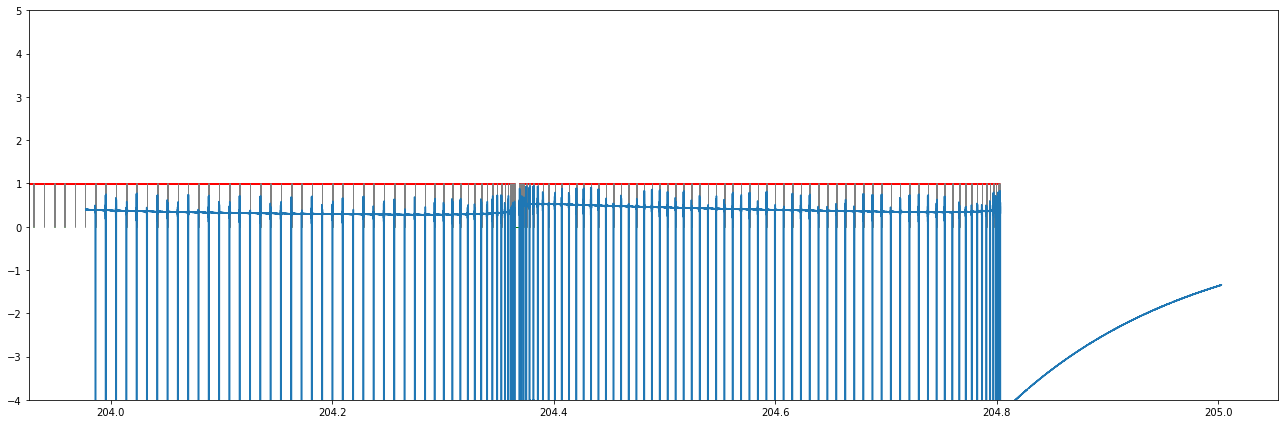

In [27]:
#eosprintInfo(4)
# create time chart with measured and calculated vectors
vectorGraph(4, R'C:\Users\ringel\Lokal\Python-local\ProSi3D\brosev2_19112021', 100, 99.5, corr=0)

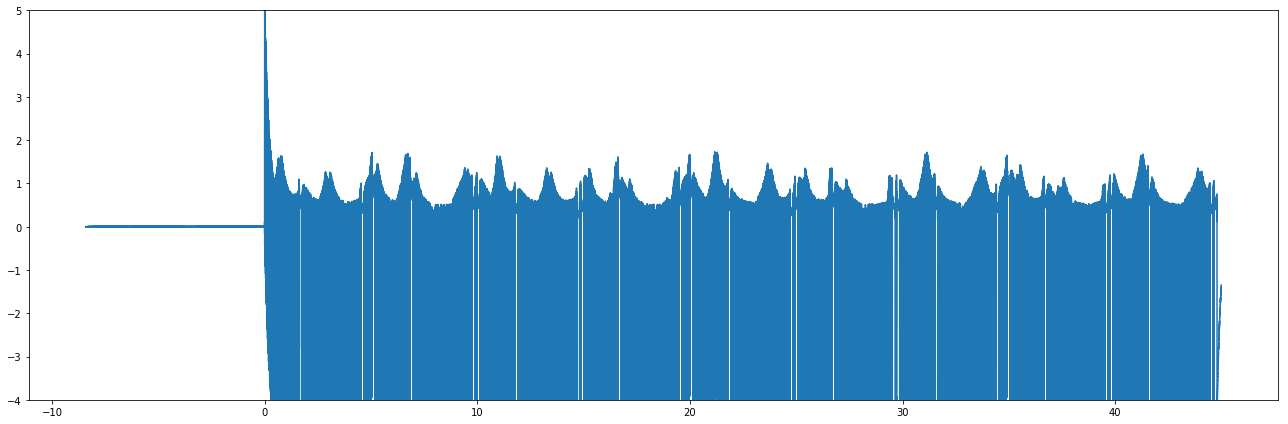

In [96]:
# plot ttl signal for one layer
plotTTL(270, path)

In [91]:
eosprintInfo(268)

eosprintInfo: INFO     >>>>>>>>>> {'layer': 268, 'vers': 1, 'logger': <Logger eosprintInfo (DEBUG)>}
eosprintInfo: INFO                    x_mm   y_mm  partId      v    dis  angle   dphi   time  cum_sum
exposureType                                                                  
2             13742  13742   13742  13742  13742  13742  13742  13742    13742
5               432    432     432    432    432    431    429    432      432


In [ ]:
data = pd.read_hdf(R'C:\Users\ringel\Lokal\Python-local\Fabian_26012022\res\eosxytime_00270.h5', key='df')

In [224]:
lb = -0.00001
ub = 0.0004
data.loc[(data['time'] > lb) & (data['time'] < ub)]

,time,lse,ttl,kse_bp,kse_rec,x_mm,y_mm,exposureType,partId,weldtime,weldId
403824,0.000000,0.069132,3.753418,5.350754,-0.041072,100.619781,94.549805,2.0,1.0,0.000038,0.0
403825,0.000020,0.062916,4.982094,5.342317,0.057178,100.607391,94.536972,2.0,1.0,NaN,0.0
403826,0.000041,0.055473,4.638981,5.487872,0.131376,100.595001,94.524147,2.0,1.0,0.000504,-1.0
403827,0.000062,0.041158,4.606773,5.699752,0.134012,NaN,NaN,2.0,1.0,NaN,-1.0
403828,0.000083,-0.023857,0.336216,5.934896,0.173262,NaN,NaN,2.0,1.0,NaN,-1.0
403829,0.000104,-0.010102,-0.039741,6.195265,0.231677,NaN,NaN,2.0,1.0,NaN,-1.0
403830,0.000125,-0.006113,-0.001578,6.387311,0.138520,NaN,NaN,2.0,1.0,NaN,-1.0
403831,0.000145,-0.001506,0.004761,6.437590,0.038475,NaN,NaN,2.0,1.0,NaN,-1.0
403832,0.000166,-0.001744,-0.013955,6.415106,0.042516,NaN,NaN,2.0,1.0,NaN,-1.0
403833,0.000187,0.000000,0.008465,6.394554,-0.071435,NaN,NaN,2.0,1.0,NaN,-1.0


In [169]:
data.weldId.unique().shape[0], data.weldId.max()

(6705, 6794.0)

In [218]:
eosprintInfo(270)

eosprintInfo: INFO     >>>>>>>>>> {'layer': 270, 'vers': 1, 'logger': <Logger eosprintInfo (DEBUG)>}
eosprintInfo: INFO                    x_mm   y_mm  partId      v    dis  angle   dphi   time  \
exposureType                                                            
2             13160  13160   13160  13160  13160  13160  13160  13160   
5               432    432     432    432    432    431    429    432   

              cum_sum_old  cum_sum  cusu_diff  cusu_diff_old  
exposureType                                                  
2                   13160    13160      13160          13160  
5                     432      432        432            432  


tJumpTTL    : INFO     >>>>>>>>>> {'layer': 270, 'sampling_ms': 0.02, 'logger': <Logger tJumpTTL (DEBUG)>}
tJumpTTL    : INFO     median sampling time steps median [ms]: 0.021000000000270802
tJumpTTL    : INFO     Measured jump samples: 621004 (rec: 403824) with total time 12.937441999999796 (rec: 8.412917); count: 6607
tJumpTTL    : INFO     Measured laser samples: 1942194 with total time 40.46196200000021; count: 6606
tJumpTTL    : INFO     Total layer time: 53.399404000000004 started at 53.399404000000004


measured jumps: 6606, welds: 6606
Row count in eos uneven: False; 13614


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Vector count where weld changes without measurable jump (e.g. boarders with zero jumps.): 27
Measureable eos-welds: 6618 - measured ttl-welds: 6607 = not measured: 11
swelds: [0, 202, 568, 866, 940, 1223, 1271, 1554, 1800, 2152, 2395, 2506, 2616, 2704, 2705, 2816, 2926, 3062, 3275, 3311, 3438, 3625, 3823, 5231, 5403, 5546, 5728, 5959, 6270, 6289]
27 boarders found.
Last contourweld is shifted by 11; missing weld count is: 11
8 shifted boarders: [1940, 2292, 2617, 2927, 3439, 3789, 6271, 6601]
True boarders positions are: [1939, 2290, 2613, 2920, 3431, 3780, 6261, 6590]
Assigned shifts: [1.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0]
>>>>>>>>> while loop: 0 of 10 (forecast) with eosshape: 6618
sweld count 30
Found swelds: Int64Index([   0,  202,  568,  866,  940, 1223, 1271, 1554, 1800, 2152, 2395,
            2506, 2616, 2704, 2705, 2816, 2926, 3062, 3275, 3311, 3438, 3625,
            3823, 5231, 5403, 5546, 5728, 5959, 6270, 6289],
           dtype='int64')
index loss_viol = 1814
     idx  

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


combined true eos indexes: (6538, 6540)
Combination not solved in further functions (18.02.2022)
       idx  exposureType  partId       dis       time    cum_sum  cusu_onettl  \
3177  6536             2      13  9.450804  10.182958  20.578374          0.0   
3178  6538             2      13  3.549038  10.258250  20.589640          0.0   
3179  6540             2      13  5.971644   6.434268  20.589640          0.0   
3180  6542             2      13  5.839122   6.291479  20.596436          0.0   
3181  6544             2      13  3.549044   3.823988  20.600764          0.0   

         ttl      loss   diffeos  diffttl      loss2  
3177  10.249 -0.006486  0.081327    0.082  -0.008274  
3178  10.334 -1.702418 -6.358976    0.085   1.013367  
3179   6.354  0.012475  2.610285   -3.980   2.524738  
3180   3.896  0.380750 -0.142788   -2.458 -16.214281  
3181   3.875 -0.013340 -2.467491   -0.021   0.991489  
Missing jump drop 3179 moves loss forwards (3527). Drop accepted.
>>>>>>>>> while loop

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


combined true eos indexes: (7252, 7254)
Combination not solved in further functions (18.02.2022)
       idx  exposureType  partId       dis       time    cum_sum  cusu_onettl  \
3526  7250             2      14  9.450820  18.354670  22.814856          0.0   
3527  7252             2      14  3.549044  18.490687  22.834355          0.0   
3528  7254             2      14  5.971811  11.598002  22.834355          0.0   
3529  7256             2      14  5.839289  11.340628  22.846199          0.0   
3530  7258             2      14  3.549043   6.892685  22.853596          0.0   

         ttl      loss    diffeos  diffttl      loss2  
3526  18.438 -0.004540   0.146580    0.168  -0.146129  
3527  18.583 -1.696047 -11.461985    0.145   1.012651  
3528  11.417  0.015606   4.705317   -7.166   2.522958  
3529   6.958  0.386454  -0.257374   -4.459 -16.324958  
3530   6.958 -0.009476  -4.447943    0.000   1.000000  
Missing jump drop 3528 moves loss forwards (5959). Drop accepted.
>>>>>>>>> whil

In [11]:
#ttlraw = pd.read_hdf(R'C:\Users\ringel\Lokal\Python-local\Fabian_26012022\ttl\ch4raw_00270.h5')
ttlraw = pd.read_hdf(R'C:\Users\ringel\Lokal\Python-local\ProSi3D\brosev2_19112021\ttl\ch4raw_00004.h5')

In [12]:
ttlraw.head(2)

,time,lse,ttl,kse_bp,kse_rec
0,0.000000,0.000486,-1.419289,0.022819,0.003798
1,0.000021,0.000590,-1.420467,0.030566,0.005527


In [20]:
eosraw = pd.read_hdf(R'C:\Users\ringel\Lokal\Python-local\ProSi3D\brosev2_19112021\tests\eoslaserpath-ttlcor_00004.h5')
eosraw.head()

,x_mm,y_mm,exposureType,partId,v,dis,angle,dphi,time,cum_sum_old,cum_sum,cusu_diff,cusu_diff_old,diff_mono
0,72.080002,3.08,10,5,2000.0,5.839996,180.0,270.0,0.00292,0.00292,0.00292,0.0,0.0,NaN
1,77.919998,3.08,10,5,1480.0,0.000000,0.0,0.0,0.00000,0.00292,0.00292,0.0,0.0,0.00000
2,77.919998,3.08,10,5,2000.0,0.040000,-90.0,-90.0,0.00002,0.00294,0.00294,0.0,0.0,0.00002
3,77.919998,3.12,10,5,1480.0,0.000000,0.0,0.0,0.00000,0.00294,0.00294,0.0,0.0,0.00000
4,77.919998,3.12,10,5,2000.0,5.839996,0.0,-90.0,0.00292,0.00586,0.00586,0.0,0.0,0.00292


In [93]:
sweld = swelds_viol.iloc[0]
sweld
ttlDropLst

[1368]

In [90]:
n = 5
lsr_strt_jmp_len.loc[1368-n:1368+n]
eos.loc[2791-n:2791+n]

,level_0,index,time,ttl,diffs,cum-sum,idx,diff_idx,prev_idx,diff_ms,timelaser
1363,1363,872589,18.178756,0.967176,0.000021,8.488428,872589,26.0,872563.0,0.542,9.343303
1364,1364,872773,18.182589,0.974168,0.000021,8.491741,872773,26.0,872747.0,0.541,9.347136
1365,1365,872960,18.186485,0.943254,0.000021,8.495116,872960,26.0,872934.0,0.542,9.351032
1366,1366,873150,18.190443,-0.397890,0.000020,8.498574,873150,25.0,873125.0,0.520,9.354990
1367,1367,873212,18.191735,0.951163,0.000021,8.499345,873212,26.0,873186.0,0.542,9.356282
1368,1369,873531,18.198381,0.675204,0.000021,8.504970,873531,26.0,873505.0,0.542,9.362928
1369,1370,873572,18.199235,0.969806,0.000021,8.505220,873572,30.0,873542.0,0.625,9.363782
1370,1371,873731,18.202548,0.303356,0.000021,8.508033,873731,25.0,873706.0,0.521,9.367095
1371,1372,873891,18.205881,0.977337,0.000021,8.510845,873891,26.0,873865.0,0.542,9.370428
1372,1373,874050,18.209193,0.900549,0.000020,8.513657,874050,25.0,874025.0,0.520,9.373740


In [104]:
eos.loc[eos['diff_mono'] < 0]

,x_mm,y_mm,exposureType,partId,v,dis,angle,dphi,time,cum_sum_old,cum_sum,cusu_diff,cusu_diff_old,diff_mono
2791,112.522018,100.429642,2,5,1480.0,0.107144,-96.961052,-248.961029,0.000504,9.248178,9.356282,0.0,0.108104,-0.0022


count    5960.000000
mean       -0.025681
std         0.029096
min        -0.550750
25%        -0.040060
50%        -0.019941
75%        -0.006898
max         0.807616
Name: loss, dtype: float64

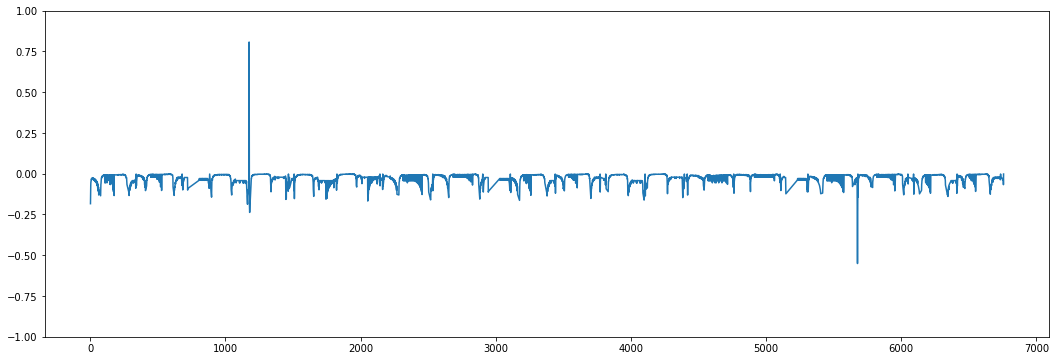

In [108]:
plt.figure(figsize=(18,6))
plt.ylim(-1, 1)
a = 0
b = 10000
t = 0.5
plt.plot(eos_laser_single.loc[eos_laser_single.time > t].index[a:b], eos_laser_single.loc[eos_laser_single.time > t].loss.iloc[a:b])
eos_laser_single.loc[eos_laser_single.time > t].loss.iloc[a:b].describe()

In [23]:
loss_prv = eos_laser_single['loss'].loc[(eos_laser_single['time'] > 1) & (eos_laser_single['time'] < 2) & (eos_laser_single.index < idx)][-9:]
loss_nxt = eos_laser_single['loss'].loc[(eos_laser_single['time'] > 1) & (eos_laser_single['time'] < 2) & (eos_laser_single.index > idx)][:9]
loss_prv_mn = loss_prv.mean()
loss_nxt_mn = loss_nxt.mean()
loss_prv_sd = loss_prv.std()
loss_nxt_sd = loss_nxt.std()

print(f"prev: {loss_prv_mn} +- {loss_prv_sd} , next: {loss_nxt_mn} +- {loss_nxt_sd}")

prev: -0.05131016758975294 +- 0.010802451921875705 , next: -1.6292919525626066 +- 2.206948961578639


<BarContainer object of 6758 artists>

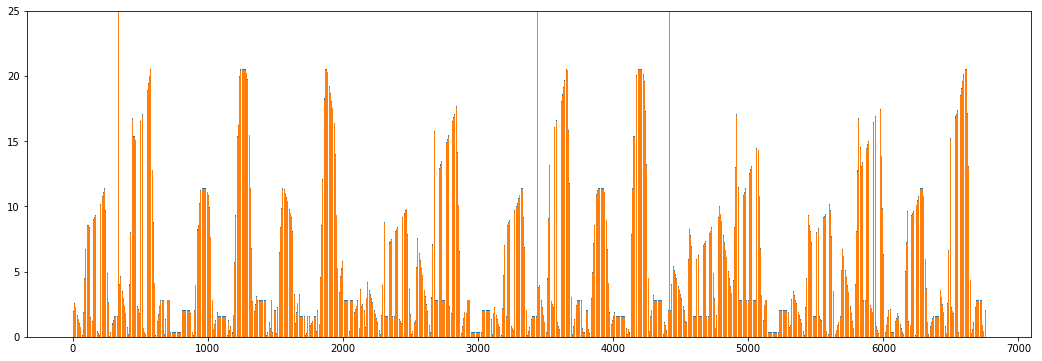

In [38]:
plt.figure(figsize=(18,6))
plt.ylim(0, 25)
a = 0
b = -1
plt.bar(eos_laser_single.loc[eos_laser_single.time > 0].index[a:b], eos_laser_single.loc[eos_laser_single.time > 0].ttl.iloc[a:b])
plt.bar(eos_laser_single.loc[eos_laser_single.time > 0].index[a:b], eos_laser_single.loc[eos_laser_single.time > 0].time.iloc[a:b])

In [631]:
fullttl = pd.read_hdf(R"C:\Users\ringel\Lokal\Python-local\Fabian_26012022\ttl\ch4raw_00270.h5")
power = fullttl.time.loc[fullttl.ttl > 1].iloc[0]
print(power)
fullttl = fullttl.loc[(fullttl.time > power + 20.55) & (fullttl.time < power + 20.61)]
fullttl['diff'] = fullttl.time.diff()
fullttl['diff'].describe()

8.412917


count    2.879000e+03
mean     2.083328e-05
std      3.727945e-07
min      2.000000e-05
25%      2.100000e-05
50%      2.100000e-05
75%      2.100000e-05
max      2.100000e-05
Name: diff, dtype: float64